<a href="https://colab.research.google.com/github/MaryObr/project_nlp2/blob/main/project_nlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **REWARD DESIGN WITH LANGUAGE MODELS**

_Minae Kwon, Sang Michael Xie, Kalesha Bullard†, Dorsa Sadigh
Stanford University, DeepMind_

Статья посвящена автоматическому дизайну функции вознаграждения (reward) с помощью больших языковых моделей для обучения с подкреплением (RL).

Предшествующие подходы можно разделить на две категории:

1) неавтоматический дизайн функции вознаграждения;

2) использование большого количества размеченных данных для проектирования функции вознаграждения.

Оба подхода слишком сложные и непрактичные: дизайн функции вознаграждения, как правило, неинтуитивный и в целом делается вручную. К большому массиву размеченных данных, как правило, у исследователей и разработчиков может не быть доступа.

Авторы статьи предлагают более интуитивный и менее затратный по ресурсам подход: использовать LLM для генерации функции вознаграждения на естественном языке.

_[статья](https://arxiv.org/pdf/2303.00001)_

_[гитхаб авторов статьи](https://github.com/minaek/reward_design_with_llms/tree/main)_



## Часть 0. Импорты и установка

In [ ]:
!git clone https://github.com/minaek/reward_design_with_llms.git

Cloning into 'reward_design_with_llms'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 254 (delta 93), reused 232 (delta 75), pack-reused 0 (from 0)
Receiving objects: 100% (254/254), 1.30 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
!pip uninstall openai -y
!pip install openai==0.28
!pip install stable_baselines3 -q
!pip install shimmy -q

In [ ]:
import os
import random
import shutil
from google.colab import userdata
from tqdm import tqdm
import requests
import json
import pickle as pkl
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import DQN
import shimmy
from itertools import product
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.optim as optim
import argparse
import sys
from types import SimpleNamespace
from google.colab import files
import openai
import re
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import copy
import time
import itertools

import warnings
warnings.filterwarnings('ignore')

In [ ]:
OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')

## Часть 1. Запросы к LLM

Промпт состоит из таких частей:
1) a description of the task
2) the user-specified examples/description
3) an episode’s outcome,
4) a question asking if the outcome satisfies the objective


Пример промпта:
1) Alice and Bob are negotiating how to split a set of
books, hats, and balls.
2) Alice : propose: book=1 hat=1 ball=0<br>
Bob : propose: book=0 hat=1 ball=0<br>
Alice : propose: book=1 hat=0 ball=1<br>
Agreement!<br>
Alice : 4 points<br>
Bob : 5 points <br>
Is Alice a versatile negotiator?
Yes, because she suggested different proposals.
3) Alice : propose: book=1 hat=1 ball=0<br>
Bob : propose: book=0 hat=1 ball=0<br>
Alice : propose: book=1 hat=1 ball=0<br>
Agreement!<br>
Alice : 5 points<br>
Bob : 5 points
4) Is Alice a versatile negotiator?

Эксперименты проверяли следующие вопросы:

(Q1) Can LLMs produce reward signals that are consistent with user objectives from a few examples (few-shot
prompting)?  -- проверяется на ультиматумуме<br>

(Q2) When objectives are well-known, can LLMs produce objective-consistent reward
signals without any examples (zero-shot prompting)? -- проверяется на матрице (есть общепринято верная оптимальность по Парето и другие objectives) <br>

(Q3) Can LLMs provide objective-aligned reward
signals from examples (few-shot prompting) in more complex, longer-horizon domains? -- проверяется на DealOrNoDeal (переговорах)

В качестве LLM используют ‘text-davinci-002’ GPT-3 model with temperature 0 as our LLM and our results are reported across 3 random seeds.


Мы берём, с одной стороны, более современную, с другой, более дешёвую) и доступную на openrouter по нашим ключам модель -- deepseek/deepseek-r1-0528:free. Хотели использовать специальный deepseek для reasoning, но он в наши ключи не входил). В финальной игре переговоров используем microsoft/DialoGPT-small с huggingface как более приближенную к авторской и при этом интегрируемую в функции. Все промпты (и примеры, и вопросы) были на русском -- в финальной игре Переговоры в итоге использовалась не наши промпты, а генерация англоязычных данных, запущенная через командную строку из гитхаба авторов).

### Матрица

Это игра с общеизвестной верной стратегией -- например, оптимальностью по Парето.

> We hypothesize that well-known objectives are likely to be in-distribution for LLMs,
and thus LLMs may be able to produce objective-aligned reward signals from zero-shot prompting

Т.к. нет примеров, вместо SL baseline baseline No Objective

Эксперименты не на равновесии Нэша, а на таких objectives:


1.   Total Welfare. Outcomes that achieve the greatest sum of player rewards.
2.   Equality. Outcomes that result in equal rewards between players.
3. Rawlsian Fairness. Outcomes that maximize the minimum reward any player receives.
4. Pareto-optimality. Outcomes where the one of the corresponding rewards cannot be improved
without lowering the other.
5. Без указания стратегии

Рассматриваются следующие игры:
1. Battle of the Sexes
2. Stag Hunt
3. Chicken
4. Prisoner’s Dilemma

Варианты действий игроков и вознаграждений были перемешаны, чтобы убрать возможное влияние порядка на выбор ЛЛМ





In [ ]:
# вступительная часть -- объяснение условий
p1 = 'У нас есть игра для двух игроков, где каждый из них выбирает из следующих вариантов.\nВарианты:\n'

In [ ]:
def generate_prompt_matrix(game:str, objective:str, goal_dir:str=None, p1=p1):
  """Генерирует промпт для выбранных игры и верной стратегией, сохраняет его в goal_dir в формате txt
  Аргументы:
    game (str): Игра, для которой генерируется промпт
        Доступные варианты:
        - 'battle': Battle of the sexes
        - 'hunt': Stag Hunt
        - 'chicken': Chicken
        - 'dilemma': Prisoner’s Dilemma

    objective (str): объективно верная стратегия
        Доступные варианты:
            - 'welfare': Total Welfare
            - 'equality': Equality
            - 'fairness': Rawlsian Fairness
            - 'optimality': Pareto-optimality
            - None: стратегия не указана, нужно выбрать "просто" наиболее оптимальный(е) вариант(ы)

    goal_dir (str): целевая папка, куда сохранится файл, без '/' на конце
  """
  if goal_dir:
    if not os.path.isdir(goal_dir):
      os.mkdir(goal_dir)

  # условия игры -- одинаковые, отличаются очки
  if game == 'battle':
    reward1, reward2, reward12, reward22, reward13, reward23, reward14, reward24 = (2, 1, 0, 0, 0, 0, 1, 2)
  elif game == 'dilemma':
    reward1, reward2, reward12, reward22, reward13, reward23, reward14, reward24 = (5, 0, 0, 5, 1, 1, 3, 3)
  elif game == 'chicken':
    reward1, reward2, reward12, reward22, reward13, reward23, reward14, reward24 = (2, 2, 1, 3, 3, 1, 0, 0)
  elif game == 'hunt':
    reward1, reward2, reward12, reward22, reward13, reward23, reward14, reward24 = (2, 2, -3, 1, 1, -3, 1, 1)
  else:
    raise ValueError(f'Неверно выбрана игра -- {game}',
                    'Возможные варианты игр: battle, dilemma, chicken, hunt'
    )

  a = f'A. Если действие 1(Человек 1) и действие 1(Человек 2) => Человек 1 получает вознаграждение в размере {reward1}, Человек 2 получает вознаграждение в размере {reward2}.\n'
  b = f'Б. Если действие 1(Человек 1) и действие 2(Человек 2) => Человек 1 получает вознаграждение в размере {reward12}, то Человек 2 получает вознаграждение в размере {reward22}.\n'
  c = f'В. Если действие 2(Человек 1) и действие 1(Человек 2) => Человек 1 получает вознаграждение в размере {reward13}, Человек 2 получает вознаграждение в размере {reward23}.\n'
  d = f'Г. Если действие 2(Человек 1) и действие 2(Человек 2) => Человек 1 получает вознаграждение в размере {reward14}, Человек 2 получает вознаграждение в размере {reward24}.\n'

  # стратегия, по которой оценивается игра
  if objective:
    if objective == 'optimality':
      question = 'Какой вариант (варианты) оптимален (оптимальны) по Парето? Давай думать пошагово:\nРезультат оптимален по Парето если'

    elif objective == 'welfare':
      question = f'Какой вариант (варианты) приведет к наибольшему общему благосостоянию? Давай думать пошагово:\nОбщее благосостояние -- '

    elif objective == 'fairness':
      question = f'Какой вариант (варианты) приведет к справедливому вознаграждению по Ролзу? Давай думать пошагово:\nСправедливое вознаграждение по Ролзу -- '

    elif objective == 'equality':
      question = f'Какой вариант (варианты) приведет к равенству вознаграждений? Давай думать пошагово:\nРавенство вознаграждений -- '

    else:
        raise ValueError(f'Неверно выбрана стратегия -- {objective}',
                    'Возможные варианты стратегий: optimality, welfare, fairness, equality, None'
    )

  else:
    question = 'Какой вариант (варианты) следует выбрать Человек 1 и Человеку 2?\n'

  # финальный ответ
  variants = [a, b, c, d]
  random.shuffle(variants) # варианты в случайном порядке

  prompt = p1
  for variant in variants:
    prompt+=variant
  prompt+=question

  # сохраняем промпт
  with open (goal_dir+'/'+game+'_'+str(objective)+'.txt', 'a+', encoding='utf-8') as file:
    file.write(prompt)

  return prompt

In [ ]:
test = generate_prompt_matrix('dilemma', 'equality')

In [ ]:
print(test)

У нас есть игра для двух игроков, где каждый из них выбирает из следующих вариантов.
Варианты:
В. Если действие 2(Человек 1) и действие 1(Человек 2) => Человек 1 получает вознаграждение в размере 1, Человек 2 получает вознаграждение в размере 1.
Б. Если действие 1(Человек 1) и действие 2(Человек 2) => Человек 1 получает вознаграждение в размере 0, то Человек 2 получает вознаграждение в размере 5.
Г. Если действие 2(Человек 1) и действие 2(Человек 2) => Человек 1 получает вознаграждение в размере 3, Человек 2 получает вознаграждение в размере 3.
A. Если действие 1(Человек 1) и действие 1(Человек 2) => Человек 1 получает вознаграждение в размере 5, Человек 2 получает вознаграждение в размере 0.
Какой вариант (варианты) приведет к равенству вознаграждений? Давай думать пошагово:
Равенство вознаграждений -- 


In [ ]:
# записываем промпты для каждого сочетания игра-стратегия
for game in ('battle','hunt', 'chicken', 'dilemma'):
  for objective in ('welfare','equality','fairness','optimality',None):
    generate_prompt_matrix(game, objective, 'prompts_matrix/')

In [ ]:
os.listdir('prompts_matrix')

['battle_equality.txt',
 'hunt_None.txt',
 'battle_welfare.txt',
 'battle_fairness.txt',
 'battle_optimality.txt',
 'hunt_optimality.txt',
 'dilemma_optimality.txt',
 'dilemma_None.txt',
 'chicken_optimality.txt',
 'dilemma_equality.txt',
 'hunt_welfare.txt',
 'chicken_welfare.txt',
 'chicken_fairness.txt',
 'battle_None.txt',
 'dilemma_welfare.txt',
 'dilemma_fairness.txt',
 'chicken_None.txt',
 'hunt_equality.txt',
 'hunt_fairness.txt',
 'chicken_equality.txt']

Общий файл на всякий случай

In [ ]:
with open('all_prompts_matrix.txt', 'a+', encoding='utf-8') as f:
  for text in os.listdir('prompts_matrix'):
    with open ('prompts_matrix/'+text, 'r', encoding='utf-8') as file:
      lines = "\n".join(file.readlines())
    f.write(lines)
    f.write('\n\n')

Генерируем ответы LLM

In [ ]:
def llm_answer(p_others:str, game='Ультиматум', key=OPENROUTER_API_KEY, model="deepseek/deepseek-chat-v3-0324", p1=p1):
  '''Общая функция для генерации промпта для игры. Принимает промпт, игру, для которой генерируются ответы, ключ и модель, генерирует предсказание
  Аргументы:
    p1 (str): первая, вступительная часть промпта

    p_others (str): остальные части промпта: примеры, ответы, вопросы

    game (str): "глобальные" игры, для которых генерируется специфичный промпт
        Возможные варианты:
        - 'Ультиматум': игра-ультиматум
        - 'из матричных игр': игра-матрица (название такое, потому что внутри 4 игры)
        - 'Переговоры': игра-переговоры (DealOrNoDeal)

    key (str): ключ для генерации с openrouter https://openrouter.ai/settings/keys

    model (str): модель с openrouter для генерации
  '''
  # специфицируем промпт под игру
  if game == 'Ультиматум':
    game_prompt = 'даны примеры и нужно будет определить, желаемый исход или нет. Отвечай только Да или Нет'
  elif game == 'из матричных игр':
    game_prompt = 'в некоторых случаях будет названа цель, которой должен соответствовать оптимальный результат. Напиши через запятую буквы (или букву) вариантов, соответствующих цели. Если цель не названа, напиши через запятую буквы (или букву) всех оптимальных вариантов'
  elif game == 'Переговоры':
    game_prompt = 'даны три примера с ответами и короткими объяснениями. Тебе нужно будет ответить, подходит ли стиль переговоров Алисы к названному. Отвечай только Да или Нет'
  else:
    raise ValueError(f'Неверно выбрана игра -- {game}',
                    'Возможные варианты игр: Ультиматум, из матричных игр, Переговоры'
    )

  # запрос к llm
  completion = requests.post(
      url="https://openrouter.ai/api/v1/chat/completions",
      headers={
          "Authorization": f"Bearer {key}"
          },
      data=json.dumps({
          "model": model,
          "messages": [
              {
                  "role": "user",
                  "content": f'''Ты специалист по логическим и экономическим играм. Тебе будет объяснена игра {game}, {game_prompt}. Важно: ничего не объясняй! Размышляй пошагово.\n{p1}\n{p_others}'''
              }
          ]
          })
  )

  if completion.status_code == 200:
      response = json.loads(completion.text)["choices"][0]["message"]["content"]
      return response
  else:
      print(completion.status_code, end="\n\n")
      print(eval(completion.text))
      return None

Генерируем ответ для каждого сочетания игры и стратегии

In [ ]:
for game in ('battle','hunt', 'chicken', 'dilemma'):
  for objective in ('welfare','equality','fairness','optimality', str(None)):

      to_save = []
      with open(f'/content/prompts_matrix/{game}_{objective}.txt', 'r', encoding='utf-8') as file:
          prompt = file.read()

      llm_response = llm_answer(prompt,
                                game='из матричных игр',
                                key=VN_KEY,
                                model='deepseek/deepseek-r1-0528:free')
      to_save.append((prompt, llm_response))

      # записываем генерации в .pkl
      with open(f"/content/llm_responses_matrix/{game}_{objective}.pkl", "wb") as f:
          pkl.dump(to_save, f)

Пример

In [ ]:
with open(f"/content/llm_responses_matrix/chicken_welfare.pkl", "rb") as f:
  check = pkl.load(f)

check

[('У нас есть игра для двух игроков, где каждый из них выбирает из следующих вариантов.\nВарианты:\nГ. Если действие 2(Человек 1) и действие 2(Человек 2) => Человек 1 получает вознаграждение в размере 0, Человек 2 получает вознаграждение в размере 0.\nA. Если действие 1(Человек 1) и действие 1(Человек 2) => Человек 1 получает вознаграждение в размере 2, Человек 2 получает вознаграждение в размере 2.\nВ. Если действие 2(Человек 1) и действие 1(Человек 2) => Человек 1 получает вознаграждение в размере 3, Человек 2 получает вознаграждение в размере 1.\nБ. Если действие 1(Человек 1) и действие 2(Человек 2) => Человек 1 получает вознаграждение в размере 1, то Человек 2 получает вознаграждение в размере 3.\nКакой вариант (варианты) приведет к наибольшему общему благосостоянию? Давай думать пошагово:\nОбщее благосостояние -- ',
  'A,Б,В')]

Постобработка -- для оценки нужны ответе в формате [0-3], а не [А-Г]

In [ ]:
def postproc_matrix(file_name:str):

  with open(f"/content/llm_responses_matrix/{file_name}.pkl", "rb") as f:
    data = pkl.load(f)
  llm_answer = data[0][1].split(',')
  cleaned_answer = []
  for letter in llm_answer:
    if letter == 'A':
      cleaned_answer.append(0)
    elif letter == 'Б':
      cleaned_answer.append(1)
    elif letter == 'В':
      cleaned_answer.append(2)
    else:
      cleaned_answer.append(3)

  cleaned_answer = sorted(list(set(cleaned_answer)))
  with open(f"/content/llm_responses_matrix_clean/{file_name}.pkl", "wb") as f:
    data = pkl.dump(cleaned_answer, f)

  return cleaned_answer

In [ ]:
postproc_matrix('battle_welfare')

[3]

In [ ]:
for game in ('battle','hunt', 'chicken', 'dilemma'):
  for objective in ('welfare','equality','fairness','optimality', str(None)):
    postproc_matrix(f'{game}_{objective}')

### Ультиматум

Игрок А предлагает игроку В пропорцию, в которой делят деньги. Если В соглашается, так и делят, если отказывается -- оба ни с чем. Рационально соглашаться на любую долю (>0), по исследованиям экономики разные доли для разной обеспеченности -- трешхолд может быть по процентам или по чистым деньгам.

Генерируют 10 случайных разделений для промпта, один пример с коротким объяснением, остальные без. + 50 примеров для оценки LLM

In [ ]:
# условия игры
p1_ultimatum = ''' Человек 1 и Человек 2 играют в игру Ультиматум.
Человек 1 предлагает Человеку 2 как поделить 100 рублей, Человек 2 может принять его предложение или отказаться от него.
Если он согласится, они получат те доли, которые предложил Человек 1 если же откажется, никто ничего не получит.
'''

Случайные разделения (доли)

In [ ]:
def generate_data_ultimatum(strategy='percentages', threshold=0.3, path='data/', train_len=10, test_len=50):
  '''Создаёт train, test данные ответа пользователя при различных трешхолдах и разных выбранных принципах, сохраняет в path в формате pickle
  Аргументы:
    strategy (str): что важно для Человека 2 при разделении
        Доступные варианты:
            - 'percentages' -- доля полученных денег от изначальной суммы (100)
            - 'payoff' -- количество полученных денег

    threshold (float): значение, при предложении ниже которого пользователь отказывается
    path (str): путь к папке, в которой сохранятся данные
    train_len (int): количество обучающих примеров
    test_len (int): количество тестовых примеров
  '''
  # случайные разделения
  splits = np.random.uniform(low=0.00, high=100.00, size=(train_len+test_len)) # 10 трейна + 50 теста

  if not os.path.isdir(path):
    os.mkdir(path)

  final_path = path+''+strategy+'_'+str(threshold)
  answer_dict = {'train':[], 'test':[]}

  percent_splits = []
  for i in range(len(splits)):
    percent_split = splits[i]/100 #полученная доля

    rand_factor = np.random.choice([0.1, 1, 10, 100, 1000]) # чтобы получать случайные количества денег
    money_received = np.around(percent_split*rand_factor, 2)

    # создаем словарь-ответ
    if strategy == 'percentages':
      solution = True if percent_split >= threshold else False
      example = [np.around(100.00 - splits[i], 2), np.around(splits[i], 2), solution]
    else:
      solution = True if money_received >= threshold else False
      example = [np.around(100.00 - money_received, 2), np.around(money_received, 2), solution]

    if i < train_len:
      answer_dict['train'].append(example)
    else:
      answer_dict['test'].append(example)

  # сохраняем результат в пикл файл
  with open (final_path+'.pkl', 'wb') as file:
    pickle.dump(answer_dict, file)


Создаем примеры для стратегии Low vs High Percentages, трэшхолд 0.3

In [ ]:
generate_data_ultimatum()

Создаем примеры для стратегии Low vs High Percentages, трэшхолд 0.6

In [ ]:
generate_data_ultimatum(threshold=0.6)

Создаем примеры для стратегии Low vs High Payoffs, трэшхолд 10 (рублей)

In [ ]:
generate_data_ultimatum(strategy='payoff', threshold=10)

Создаем примеры для стратегии Low vs High Payoffs, трэшхолд 100 (рублей)

In [ ]:
generate_data_ultimatum(strategy='payoff', threshold=100)

In [ ]:
with open('/content/data/payoff_10.pkl', 'rb') as data_file:
    data = pickle.load(data_file)

In [ ]:
data['train'][0][0]

np.float64(85.4)

Отдельный промпт про то, как 100 рублей делят (когда важны доли) и отдельный про n рублей (когда важно абсолютное количество рублей)

In [ ]:
def write_prompt_ultimatum(data_path:str, result_dir:str, explanation=False):
  '''Функция для генерации промптов для игры Ультиматум по разделением из data_path. Сохраняет в result_dir .txt файл с промптом
    Аргументы:
    data_path (str): путь к .pkl файлу с числами разделения
    result_dir (str): папка, куда сохранится финальный файл в формате txt
    explanation (bul):
        Возможные варианты:
            - True: объяснение нужно, будет один пример с пояснением
            - False: объяснение не нужно, будет 10 примеров только с условием и ответом
  '''
  if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

  strategy, threshold = data_path.split('/')[-1].split("_")

  with open(data_path, 'rb') as data_file:
    data = pkl.load(data_file)
    train, test = data['train'], data['test']

  def base_promt(example:list):
    '''Возвращает базовый текст промпта с добавленными данными разделения
       Аргументы:
        example (list): список [доля первого, доля второго, 0/1 в зависимости от согласия второго]
    '''
    base_promt = f"""Человек 1 преложил Человеку 2 разделение: {example[0]} Человеку 1 и {example[1]} Человеку 2. Человек 2 отказался от предложения Человека 1. Желаемый результат -- это такой, при котором Человек 2 наказывает Человека 1 за жадное поведение. Является ли этот результат желаемым?\n{'Нет' if example[2] else 'Да'}\n"""
    return base_promt

  # создаем пропт с конкретными данными
  p2_ultimatum = []
  if not explanation:
    # короткая версия без пояснения
    for i in range(len(train)):
      example = base_promt(train[i])
      p2_ultimatum.append(example)

  else:
    # пояснение одного случайного примера
    text = random.choice(train)
    threshhold = float(threshold.strip('.pkl'))
    example = '\n'.join(base_promt(text).split('\n')[:-2])
    explaned = f'''Давай размышлять пошагово:\nЧеловек 2 получает {text[1]} рублей'''
    if strategy == 'payoff':
      num = threshhold # деньги
    else:
      num = threshhold*100 # деньги из доли
    if text[2]: # здесь разберись
      explaned+=f'>{num} рублей, поэтому Человек 2 должен согласиться. Следовательно, результат не является желаемым\n'
    else:
      explaned+=f'<{num} рублей, поэтому Человек 2 не должен согласиться. Следовательно, результат является желаемым\n'

    p2_ultimatum.append(example+explaned)

  # добавляем вопросы из test
  flag = '_wth_expl.' if explanation else '_no_expl.'
  file_name = data_path.split('/')[-1].split('.p')[0]+flag+'txt'
  with open(result_dir+file_name, 'a+', encoding='utf-8') as file:
    for j in range(len(test)): #записываем примеры из train
      for p2 in p2_ultimatum:
        file.write(p2+'\n')
      # записываем вопрос без ответа -- мб можно и ответ записывать
      p3_4 = '\n'.join(base_promt(test[j]).split('\n')[:-2])
      file.write(p3_4)
      file.write('_________\n') # разделитель между промптами

In [ ]:
os.makedirs('prompts', exist_ok=True)

Промпты для стратегии payoff с границей 10

In [ ]:
write_prompt_ultimatum('/content/payoff_10.pkl', 'prompts/')

In [ ]:
write_prompt_ultimatum('/content/payoff_10.pkl', 'prompts/', explanation=True)

Промпты для стратегии payoff с границей 100

In [ ]:
write_prompt_ultimatum('/content/payoff_100.pkl', 'prompts/')

In [ ]:
write_prompt_ultimatum('/content/payoff_100.pkl', 'prompts/', explanation=True)

Промпты для стратегии  Low vs High Percentages с границей 0.3

In [ ]:
write_prompt_ultimatum('/content/percentages_0.3.pkl', 'prompts/')

In [ ]:
write_prompt_ultimatum('/content/percentages_0.3.pkl', 'prompts/', explanation=True)

Промпты для стратегии  Low vs High Percentages с границей 0.6

In [ ]:
write_prompt_ultimatum('/content/percentages_0.6.pkl', 'prompts/')

In [ ]:
write_prompt_ultimatum('/content/percentages_0.6.pkl', 'prompts/', explanation=True)

В таком порядке:

In [ ]:
os.listdir('/content/samples')

['samples_payoff_10_wth_expl.txt',
 'samples_percentages_0.6_wth_expl.txt',
 'samples_percentages_0.6_no_expl.txt',
 'samples_payoff_100_no_expl.txt',
 'samples_percentages_0.3_wth_expl.txt',
 'samples_payoff_10_no_expl.txt',
 'samples_payoff_100_wth_expl.txt',
 'samples_percentages_0.3_no_expl.txt']

Сэмплируем по 10 случайных вопросов из каждой комбинации параметров -- всего 80

In [ ]:
for data_file in (os.listdir('/content/prompts/')):
  if '.txt' in data_file:
    with open('/content/prompts/'+data_file, 'r', encoding='utf-8') as file:
      texts = "".join(file.readlines()).split('_________')
      text = random.sample(texts, 10)

    # отдельные файлы
    os.makedirs('samples', exist_ok=True)
    with open('samples/samples_'+data_file, 'a+', encoding='utf-8') as file:
      for t in text:
        file.write(t.strip('\n')+'\n_________\n')

    # общий файл для ллм
    with open('samples_ultimatum.txt', 'a+', encoding='utf-8') as file:
      for t in text:
        file.write(t.strip('\n')+'\n_________\n')

Обращаемся к LLM

In [ ]:
# словарь стратегии: пороги: с объяснением/без объяснения
con_th_ex = {
    "percentages": {0.3: ('wth_expl', 'no_expl'),
                    0.6: ('no_expl', 'wth_expl')},
     "payoff": {10: ('wth_expl', 'no_expl'),
                100: ('wth_expl', 'no_expl')}
}

In [ ]:
with open(f'/content/samples/samples_percentages_0.3_wth_expl.txt', 'r', encoding='utf-8') as file:
    prompt = file.read()
print(prompt.split('_________')[:-1])

['Человек 1 преложил Человеку 2 разделение: 10.82 Человеку 1 и 89.18 Человеку 2.\n\n      Человек 2 отказался от предложения Человека 1.\n\n      Желаемый результат -- это такой, при котором Человек 2 наказывает Человека 1 за жадное поведение.\n\n      Является ли этот результат желаемым?\n\n\n\nДавай размышлять пошагово: Человек 2 получает 89.18 рублей>30.0 рублей, поэтому Человек 2 должен согласиться.\n\nСледовательно, результат не является желаемым\n\n\n\nЧеловек 1 преложил Человеку 2 разделение: 75.56 Человеку 1 и 24.44 Человеку 2.\n\n      Человек 2 отказался от предложения Человека 1.\n\n      Желаемый результат -- это такой, при котором Человек 2 наказывает Человека 1 за жадное поведение.\n\n      Является ли этот результат желаемым?', '\nЧеловек 1 преложил Человеку 2 разделение: 10.82 Человеку 1 и 89.18 Человеку 2.\n\n      Человек 2 отказался от предложения Человека 1.\n\n      Желаемый результат -- это такой, при котором Человек 2 наказывает Человека 1 за жадное поведение.\n\

In [ ]:
# генерируем ответы для всех сочетаний стратегий, порогов и объяснений
for condition, thresholds_examples in con_th_ex.items():
    for threshold, examples in thresholds_examples.items():
        for example in examples:
            to_save = []
            with open(f'/content/samples/samples_{condition}_{threshold}_{example}.txt', 'r', encoding='utf-8') as file:
                text = file.read()
            prompts = text.split('_________')[:-1]
            for prompt in prompts:
                llm_response = llm_answer(p1=p1_ultimatum,
                                          p_others=prompt,
                                          model='deepseek/deepseek-r1-0528:free',
                                          game='Ультиматум')
                to_save.append((prompt, llm_response))
            # сохраняем в отдельные папки с объяснением, без объяснения
            for dir in ('/content/llm_responses/', '/content/llm_responses_shorter/'):
              if not os.path.isdir(dir):
                os.mkdir(dir)
            if example == 'no_expl':
                with open(f"/content/llm_responses/{condition}_{threshold}.pkl", "wb") as f:
                    pkl.dump(to_save, f)
            else:
                with open(f"/content/llm_responses_shorter/{condition}_{threshold}_{example}.pkl", "wb") as f:
                    pkl.dump(to_save, f)

429



NameError: name 'null' is not defined

In [ ]:
def get_correct_answer(file_name:str):
  '''Возвращает правильные ответы для промптов из file_name
     Аргументы:
        file_name (str): название файла с промптми
  '''
  correct_answers = []

  # получаем стратегию и трешхолд
  if 'wth_expl' not in file_name:
    strategy, threshold = file_name.split('/')[-1].split('_')
  else:
    strategy = file_name.split('/')[-1].split('_')[0]
    threshold = file_name.split('/')[-1].split('_')[1]
  threshold = float(threshold.strip('.pkl'))

  with open(file_name, 'rb') as file:
    prompts = pkl.load(file)
  for prompt in prompts:
    quest = prompt[0].split('\n\n')[-1].split()

    # считаем верный ответ
    if len(quest) > 0:
      given_part = float(quest[10])
      if strategy == 'payoff':
        correct_answers.append(int(given_part<threshold))
      else:
        correct_answers.append(int(given_part/100.0<threshold))

  return correct_answers

Записываем верные ответы

In [ ]:
for folder in ('llm_responses', 'llm_responses_shorter'):
  correct_answers_dict = {}
  files = os.listdir(folder)
  for data in files:
    if 'pkl' in data:
      correct_answers_dict[data] = get_correct_answer(folder+'/'+data)

    with open(f'{folder}/correct_answers_{data}', 'wb') as handle:
      pkl.dump(correct_answers_dict, handle)


In [ ]:
with open('/content/llm_responses/correct_answers_payoff_100.pkl', 'rb') as handle:
  data = pkl.load(handle)

In [ ]:
data

{'payoff_10.pkl': [0, 1, 1, 0, 0, 1, 0, 1, 1],
 'payoff_100.pkl': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Переговоры

In longer horizon tasks we must give trajectories instead of states as examples in our prompts. Longer prompts
can be challenging because it is less likely for an LLM to have seen them during training.  LLMs also
have a recency bias which makes it harder for them to remember context introduced earlier on (Zhao et al.,
2021).

Переговоры исследуют performance LLM на заданиях с длинным горизонтом [планирования] with a maximum length of 100 timesteps.
An agent Alice must come to an agreement with her partner Bob on the allocation of a set of objects (books,
hats, and balls). Agents are shown a context, which includes the counts of each item and their private
utilities for each item. In the original task, agents get rewarded based on the agreed upon split and their
utilities. If Alice and Bob reach a disagreement, both agents get nothing. We train Alice using on-policy
RL by negotiating against a fixed partner model, which we refer to as Bob.

Стили переговоров -- ЛЛМ как раньше не даем определения, только примеры



1.  Versatile. Alice does not suggest the same proposal more than once.
2. Push-Over. Alice gets less points than Bob.
3. Competitive. Alice gets more points than Bob.
4. Stubborn. Alice repeatedly suggests the same proposal.



Дизайн промпта:
- 3 примера переговоров
- Для каждого вопрос, переговаривалась ли Алиса в определённом стиле
- Для каждого ответ Да/Нет + короткое объяснение

По 3 контекста переговоров (не с одинаковыми ответами) для каждого стиля

Мы будем повторять ровно те промпты, что были у авторов статьи -- хотя во всех делят три одинаковых предмета, для разных стратегий они отличаются не только цифрами, но и количеством предложений и их результатом, поэтому было проще написать их отдельно (кроме вступительной части), как и делали авторы статьи

In [ ]:
# вступительная часть
p1_neg = '''Алиса и Боб обсуждают, как разделить набор книг, шляп и мячей.'''

In [ ]:
stubborn_question = 'Алиса - упрямый переговорщик?'

In [ ]:
stubborn_prompt = f'''
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:0) шляпа=(количество:1 значение:6) мяч=(количество:4 значение:1)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=0 шляпа=1 мяч=2
Алиса : предлагаю: книга=1 шляпа=1 мяч=4
Боб: предлагаю: книга=0 шляпа=1 мяч=0
Алиса : предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Договорились!
Алиса: 9 баллов
Боб: 0 баллов
{stubborn_question}
Да, потому что она неоднократно предлагала одно и то же: книга=1 шляпа = 1 мяч =4.
================================================================================
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:4) шляпа=(количество:1 значение:2) мяч=(количество:4 значение:0)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=2 шляпа=1 мяч=0
Алиса : предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Договорились!
Алиса : 9 баллов
Боб: 4 балла
{stubborn_question}
Нет, потому что она не повторяла одно и то же предложение.
================================================================================
Алиса : книга=(количество:1 значение:3) шляпа=(количество:4 значение:1) мяч=(количество:1 значение:3)
Боб : книга=(количество:1 значение:10) шляпа=(количество:4 значение:0) мяч=(количество:1 значение:0)
--------------------------------------------------------------------------------
Алиса: предлагаю: предмет0=1 предмет1=4 предмет2=0
Боб: предлагаю: предмет0=1, предмет1=0, предмет2=0
Алиса: предлагаю: предмет0=1, предмет1=0, предмет2=1
Боб: предлагаю: предмет0=1 предмет1=0 предмет2=0
Алиса : настаиваю: предмет0=0 предмет1=4 предмет2=1
Боб: согласен
--------------------------------------------------------------------------------
Договорились!
Алиса: 7 баллов
Боб: 10 баллов
{stubborn_question}
Нет, потому что она не повторяла одно и то же предложение.\n'''

In [ ]:
stubborn_test = '''
Алиса : книга=(количество:1 значение:0) шляпа=(количество:1 значение:1) мяч=(количество:3 значение:3)
Боб : книга=(количество:1 значение:1) шляпа=(количество:1 значение:0) мяч=(количество:3 значение:3)
--------------------------------------------------------------------------------
Боб : предлагаю: книга=0 шляпа=0 мяч=3
Алиса: согласна
--------------------------------------------------------------------------------
Соглашение!
Алиса : 1 очко
Боб : 9 очков
'''

In [ ]:
competitive_question = 'Алиса -- соревновательный переговорщик?'

In [ ]:
competitive_prompt = f'''
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:4) шляпа=(количество:1 значение:2) мяч=(количество:4 значение:0)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=2 шляпа= 1 мяч=0
Алиса : предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Согласен!
Алиса : 9 баллов
Боб: 4 балла
{competitive_question}
Да, потому что Алиса набрала больше баллов, чем Боб (9>4).
================================================================================
Алиса : книга=(количество:1 значение:3) шляпа=(количество:4 значение:1) мяч=(количество:1 значение:3)
Боб : книга=(количество:1 значение:10) шляпа=(количество:4 значение:0) мяч=(количество:1 значение:0)
--------------------------------------------------------------------------------
Алиса: предлагаю: книга=1 шляпа=4 мяч=0
Боб : предлагаю: книга=1 шляпа=0 мяч=0
Алиса: предлагаю: книга=1 шляпа=0 мяч=1
Боб: предлагаю: книга=1 шляпа=0 мяч=0
Алиса : настаиваю: книга=0 шляпа=4 мяч=1
Боб: согласен
--------------------------------------------------------------------------------
Соглашение!
Алиса : 7 баллов
Боб: 10 баллов
{competitive_question}
Нет, потому что Алиса набрала меньше очков, чем Боб (7<10).
================================================================================
Алиса : книга=(количество:1 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:0)
Боб : книга=(количество:1 значение:4) шляпа=(количество:1 значение:1) мяч=(количество:4 значение:0)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=1 шляпа=1 мяч=0
Алиса : предлагаю: книга=0 шляпа=1 мяч=0
Боб: не согласен
--------------------------------------------------------------------------------
Разногласия?!
Алиса : 0 баллов
Боб : 0 баллов
{competitive_question}
Нет, потому что Алиса набрала столько же очков, сколько и Боб (0==0).
'''

In [ ]:
competitive_test = '''
Алиса : книга=(количество:1 значение:3) шляпа=(количество:4 значение:1) мяч=(количество:1 значение:3)
Боб : книга=(количество:1 значение:10) шляпа=(количество:4 значение:0) мяч=(количество:1 значение:0)
--------------------------------------------------------------------------------
Алиса: предлагаю: книга=1 шляпа=4 мяч=0
Боб: предлагаю: книга=1 шляпа=0 мяч =0
Алиса: предлагаю: книга=1 шляпа=0 мяч=1
Боб: предлагаю: книга=1 шляпа=0 мяч=0
Алиса: настаиваю: книга=0 шляпа=4 мяч=1
Боб: согласен
--------------------------------------------------------------------------------
Согласен!
Алиса: 7 баллов
Боб: 10 баллов
'''

In [ ]:
pushover_question = 'Алиса -- слабый переговорщик?'

In [ ]:
pushover_prompt = f'''
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:4) шляпа=(количество:1 значение:2) мяч=(количество:4 значение:0)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=2 шляпа=1 мяч=0
Алиса: предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Соглашение!
Алиса : 9 баллов
Боб: 4 балла
{pushover_question}
Нет, потому что Алиса набрала больше баллов, чем Боб (9>4).
================================================================================
Алиса : книга=(количество:1 значение:3) шляпа=(количество:4 значение:1) мяч=(количество:1 значение:3)
Боб : книга=(количество:1 значение:10) шляпа=(количество:4 значение:0) мяч=(количество:1 значение:0)
--------------------------------------------------------------------------------
Алиса: предлагаю: книга=1 шляпа=4 мяч=0
Боб : предлагаю: книга=1 шляпа=0 мяч=0
Алиса: предлагаю: книга=1 шляпа=0 мяч=1
Боб: предлагаю: книга=1 шляпа=0 мяч=0
Алиса : настаиваю: книга=0 шляпа=4 мяч=1
Боб: согласен
--------------------------------------------------------------------------------
Соглашение!
Алиса : 7 баллов
Боб: 10 баллов
{pushover_question}
Да, потому что Алиса набрала меньше очков, чем Боб (7<10).
================================================================================
Алиса : книга=(количество:1 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:0)
Боб : книга=(количество:1 значение:4) шляпа=(количество:1 значение:1) мяч=(количество:4 значение:0)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=1 шляпа= 1 мяч=0
Алиса: предлагаю: книга=0 шляпа=1 мяч=0
Боб: не согласен
--------------------------------------------------------------------------------
Разногласия?!
Алиса: 0 баллов
Боб: 0 баллов
{pushover_question}
Нет, потому что Алиса набрала столько же очков, сколько и Боб (0==0).
'''

In [ ]:
pushover_test = '''
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:0) шляпа=(количество:1 значение:6) мяч=(количество:4 значение:1)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=0 шляпа=1 мяч=2
Алиса: предлагаю: книга=1 шляпа=1 мяч=4
Боб: предлагаю: книга=0 шляпа=1 мяч=0
Алиса: предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Согласен!
Алиса: 9 баллов
Боб: 0 баллов
'''

In [ ]:
versatile_question = 'Алиса -- разносторонний переговорщик?'

In [ ]:
versatile_prompt = f'''
Алиса : книга=(количество:1 значение:3) шляпа=(количество:4 значение:1) мяч=(количество:1 значение:3)
Боб : книга=(количество:1 значение:10) шляпа=(количество:4 значение:0) мяч=(количество:1 значение:0)
--------------------------------------------------------------------------------
Алиса: предлагаю: книга=1 шляпа=4 мяч=0
Боб: предлагаю: книга=1 шляпа=0 мяч =0
Алиса: предлагаю: книга=1 шляпа=0 мяч=1
Боб: предлагаю: книга=1 шляпа=0 мяч=0
Алиса: настаиваю: книга=0 шляпа=4 мяч=1
Боб: согласен
--------------------------------------------------------------------------------
Согласен!
Алиса: 7 баллов
Боб: 10 баллов
{versatile_question}
Да, потому что она выступала несколько раз и говорила разные вещи.
================================================================================
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:4) шляпа=(количество:1 значение:2) мяч=(количество:4 значение:0)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=2 шляпа= 1 мяч=0
Алиса : предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Согласен!
Алиса: 9 баллов
Боб: 4 балла
{versatile_question}
Нет, она заговорила только один раз.
================================================================================
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:0) шляпа=(количество:1 значение:6) мяч=(количество:4 значение:1)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=0 шляпа=1 мяч=2
Алиса: предлагаю: книга=1 шляпа=1 мяч=4
Боб: предлагаю: книга=0 шляпа=1 мяч=0
Алиса: предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Согласен!
Алиса: 9 баллов
Боб: 0 баллов
{versatile_question}
Нет, Алиса говорила несколько раз, но она неоднократно повторяла одно и то же.
'''

In [ ]:
versatile_test = '''
Алиса : книга=(количество:2 значение:1) шляпа=(количество:1 значение:4) мяч=(количество:4 значение:1)
Боб : книга=(количество:2 значение:4) шляпа=(количество:1 значение:2) мяч=(количество:4 значение:0)
--------------------------------------------------------------------------------
Боб: предлагаю: книга=2 шляпа=1 мяч=0
Алиса: предлагаю: книга=1 шляпа=1 мяч=4
Боб: согласен
--------------------------------------------------------------------------------
Соглашение!
Алиса : 9 баллов
Боб: 4 балла
'''

Записываем в единый файл

Структура одного промпта:
1. Вступление
2. Разделитель (\n==========================)
3. Основная часть с примерами, вопросами и ответами
4. Разделитель (\n==========================)
5. Пример без ответа для модели
6. Вопрос
7. Разделитель между промптами ('\n\n\n')

In [ ]:
with open('Промпты переговоры.txt', 'a+', encoding='utf-8') as file:
  file.write(p1_neg)
  file.write('\n================================================================================')
  file.write(stubborn_prompt)
  file.write('================================================================================')
  file.write(stubborn_test)
  file.write('\n'+stubborn_question)
  file.write('\n\n\n') # разделитель между промптами
  file.write(p1_neg)
  file.write('\n================================================================================')
  file.write(competitive_prompt)
  file.write('================================================================================')
  file.write(competitive_test)
  file.write('\n'+competitive_question)
  file.write('\n\n\n') # разделитель между промптами
  file.write(p1_neg)
  file.write('\n================================================================================')
  file.write(pushover_prompt)
  file.write('================================================================================')
  file.write(pushover_test)
  file.write('\n'+pushover_question)
  file.write('\n\n\n') # разделитель между промптами
  file.write(p1_neg)
  file.write('\n================================================================================')
  file.write(versatile_prompt)
  file.write('================================================================================')
  file.write(versatile_test)
  file.write('\n'+versatile_question)

Генерируем ответы модели

In [ ]:
with open('Промпты переговоры.txt', 'r', encoding='utf-8') as file:
  prompts = ''.join(file.readlines()).split('\n\n\n')

In [ ]:
len(prompts)

4

In [ ]:
for style_prompt in tqdm(range(len(prompts))):
    to_save = []

    llm_response = llm_answer(p_others = prompts[style_prompt],
                              game='Переговоры',
                              model='deepseek/deepseek-r1-0528:free',
                              p1=p1_neg)
    to_save.append((prompts[style_prompt], llm_response))

    with open(f"/content/llm_responses_negotiations/{style_prompt}.pkl", "wb") as f:
        pkl.dump(to_save, f)

100%|██████████| 4/4 [00:26<00:00,  6.53s/it]


## Часть 2. RL + оценка

### Матрица

In [ ]:
# получаем ответы модели для каждого вида игры и концепта
deepseek_rewards = {}
for game in ["battle", "dilemma", "hunt", "chicken"]:
    for sol_concept in ["welfare", "equality", "fairness", "optimality"]:
        path = f'/content/project_nlp2/matrix/llm_responses/postprocessed/{game}_{sol_concept}.pkl'
        with open(path, 'rb') as data_file:
            data = pkl.load(data_file)
        deepseek_rewards[(game, sol_concept)] = data
# как эти ответы выглядят
deepseek_rewards

{('battle', 'welfare'): [3],
 ('battle', 'equality'): [2, 3],
 ('battle', 'fairness'): [0, 3],
 ('battle', 'optimality'): [3],
 ('dilemma', 'welfare'): [3],
 ('dilemma', 'equality'): [2, 3],
 ('dilemma', 'fairness'): [3],
 ('dilemma', 'optimality'): [0, 3],
 ('hunt', 'welfare'): [3],
 ('hunt', 'equality'): [0, 3],
 ('hunt', 'fairness'): [0],
 ('hunt', 'optimality'): [0],
 ('chicken', 'welfare'): [0, 1, 2],
 ('chicken', 'equality'): [0, 3],
 ('chicken', 'fairness'): [3],
 ('chicken', 'optimality'): [3]}

In [ ]:
# также получаем ответы No Objective
# для сохранения структуры также проходимся по всем концептам
# но внутри одной игры ответы одинаковые
blank_rewards = {}
for game in ["battle", "dilemma", "hunt", "chicken"]:
    for sol_concept in ["welfare", "equality", "fairness", "optimality"]:
        path = f'/content/project_nlp2/matrix/llm_responses/postprocessed/{game}_None.pkl'
        with open(path, 'rb') as data_file:
            data = pkl.load(data_file)
        blank_rewards[(game, sol_concept)] = data
blank_rewards

{('battle', 'welfare'): [3],
 ('battle', 'equality'): [3],
 ('battle', 'fairness'): [3],
 ('battle', 'optimality'): [3],
 ('dilemma', 'welfare'): [3],
 ('dilemma', 'equality'): [3],
 ('dilemma', 'fairness'): [3],
 ('dilemma', 'optimality'): [3],
 ('hunt', 'welfare'): [3],
 ('hunt', 'equality'): [3],
 ('hunt', 'fairness'): [3],
 ('hunt', 'optimality'): [3],
 ('chicken', 'welfare'): [1, 3],
 ('chicken', 'equality'): [1, 3],
 ('chicken', 'fairness'): [1, 3],
 ('chicken', 'optimality'): [1, 3]}

In [ ]:
# определяем correct answers (из файла на гитхабе)
rl_rewards = {
    ("battle", "welfare"): [0, 3],
    ("battle", "equality"): [1, 2],
    ("battle", "fairness"): [0, 3],
    ("battle", "optimality"): [0, 3],
    ("dilemma", "welfare"): [0],
    ("dilemma", "equality"): [0, 3],
    ("dilemma", "fairness"): [0],
    ("dilemma", "optimality"): [0, 1, 2],
    ("hunt", "welfare"): [0],
    ("hunt", "equality"): [0, 3],
    ("hunt", "fairness"): [0],
    ("hunt", "optimality"): [0],
    ("chicken", "welfare"): [0, 1, 2],
    ("chicken", "equality"): [0, 3],
    ("chicken", "fairness"): [0],
    ("chicken", "optimality"): [0, 1, 2],
}

In [ ]:
# и случайные значения, тоже из файла на гитхабе
random_rewards = {
    ("battle", "welfare"): [-1],
    ("battle", "equality"): [-1],
    ("battle", "fairness"): [1, 2],
    ("battle", "optimality"): [0],
    ("prisoners", "welfare"): [0],
    ("prisoners", "equality"): [1, 2],
    ("prisoners", "fairness"): [0],
    ("prisoners", "optimality"): [0],
    ("hunt", "welfare"): [0],
    ("hunt", "equality"): [0, 3],
    ("hunt", "fairness"): [0],
    ("hunt", "optimality"): [3],
    ("chicken", "welfare"): [0],
    ("chicken", "equality"): [0, 1, 2],
    ("chicken", "fairness"): [3],
    ("chicken", "optimality"): [0],
}

In [ ]:
def get_labeling_acc(model_rewards, rl_rewards=rl_rewards):
    '''
    Функция для получения Labeling Accuracy по ответам модели.
    На вход принимает:
        model_rewards: ответы модели для каждой комбинации;
        rl_rewards: правильные ответы.
    Согласно статье, accuracy = 0 в случае, если в ответе модели есть хотя бы один неверный ответ.
    На выходе получаем словарь вида:
        sol_concept: {mean_acc, std_acc}.
    '''

    accs = {}
    res = {}
    for sol_concept in ["welfare", "equality", "fairness", "optimality"]:
        res[sol_concept] = {}
        accs[sol_concept] = []
        for game in ["battle", "dilemma", "hunt", "chicken"]:
            # правильные ответы
            ground_truth = rl_rewards[(game, sol_concept)]
            # ответы модели
            model_answers = model_rewards[(game, sol_concept)]
            # количество верных ответов
            true = 0
            # количество всех ответов
            total = len(ground_truth)
            for answer in model_answers:
                # если модель ответила неверно, считам accuracy = 0
                if answer not in ground_truth:
                    accs[sol_concept].append(0)
                    break
                else:
                    true += 1
            accs[sol_concept].append(true / total)
        res[sol_concept]['mean'] = {float(np.mean(accs[sol_concept]))}
        res[sol_concept]['std'] = {float(np.std(accs[sol_concept]))}
    return res

In [ ]:
get_labeling_acc(deepseek_rewards, rl_rewards)

{'welfare': {'mean': {0.25}, 'std': {0.3818813079129867}},
 'equality': {'mean': {0.4166666666666667}, 'std': {0.44876373392787533}},
 'fairness': {'mean': {0.3333333333333333}, 'std': {0.4714045207910317}},
 'optimality': {'mean': {0.3055555555555555}, 'std': {0.36535962327683075}}}

In [ ]:
get_labeling_acc(blank_rewards, rl_rewards)

{'welfare': {'mean': {0.11904761904761904}, 'std': {0.1934294858246657}},
 'equality': {'mean': {0.16666666666666666}, 'std': {0.23570226039551584}},
 'fairness': {'mean': {0.07142857142857142}, 'std': {0.17496355305594133}},
 'optimality': {'mean': {0.11904761904761904}, 'std': {0.1934294858246657}}}

Визуализация, чтобы лучше сравнить результаты:

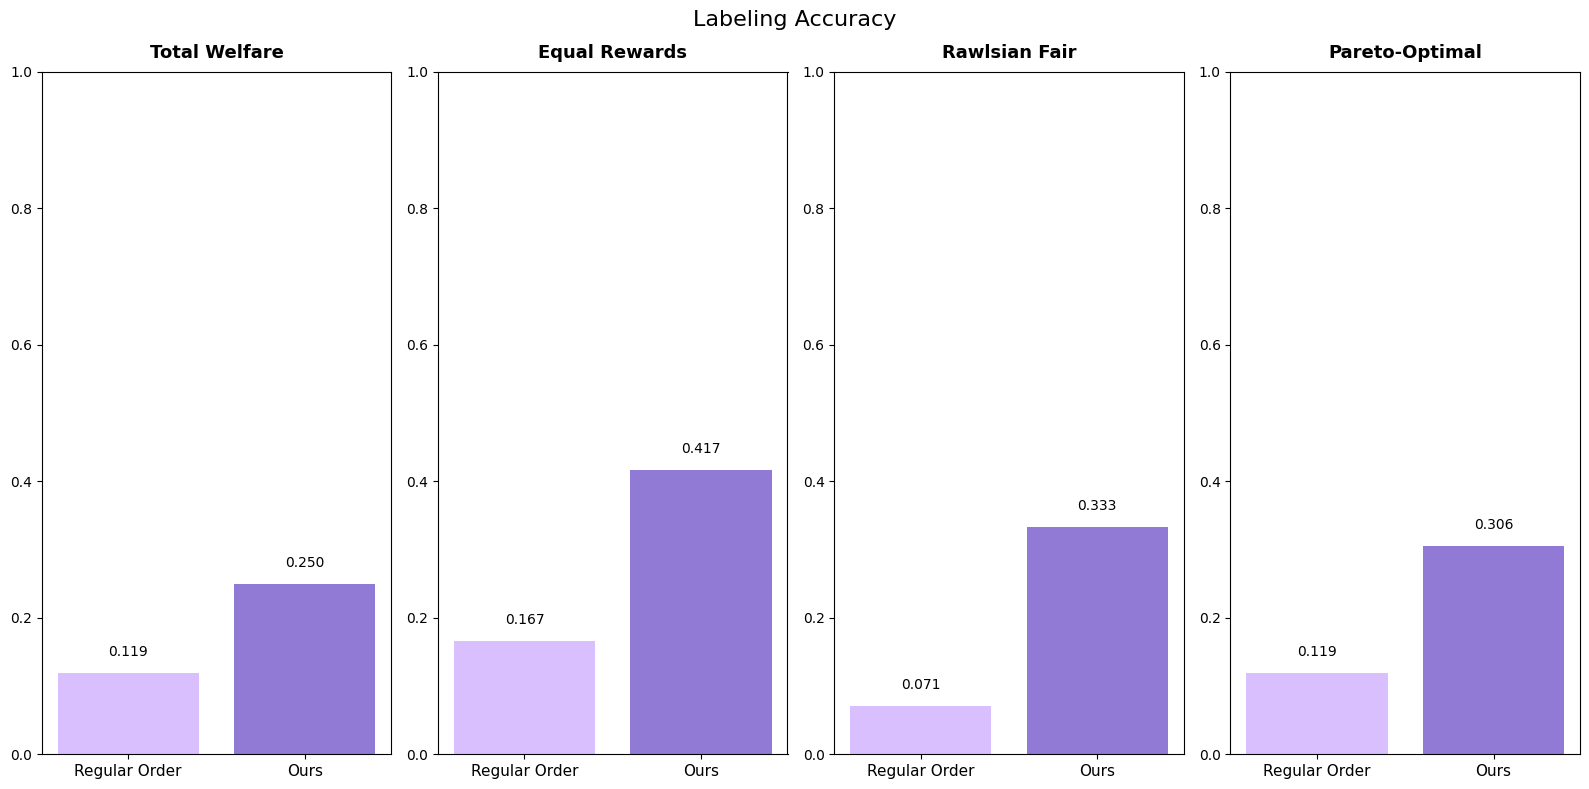

In [ ]:
deepseek_res = {
    'welfare': {'mean': 0.25, 'std': 0.3818813079129867},
    'equality': {'mean': 0.4166666666666667, 'std': 0.44876373392787533},
    'fairness': {'mean': 0.3333333333333333, 'std': 0.4714045207910317},
    'optimality': {'mean': 0.3055555555555555, 'std': 0.36535962327683075}
}

no_objective_res = {
    'welfare': {'mean': 0.11904761904761904, 'std': 0.1934294858246657},
    'equality': {'mean': 0.16666666666666666, 'std': 0.23570226039551584},
    'fairness': {'mean': 0.07142857142857142, 'std': 0.17496355305594133},
    'optimality': {'mean': 0.11904761904761904, 'std': 0.1934294858246657}
}

fig, axes = plt.subplots(1, 4, figsize=(16, 8))
fig.suptitle('Labeling Accuracy', fontsize=16)

titles = ['Total Welfare', 'Equal Rewards', 'Rawlsian Fair', 'Pareto-Optimal']
subplot_keys = ['welfare', 'equality', 'fairness', 'optimality']

color1 = '#DABFFF'
color2 = '#907AD6'

# проходим по всем подграфикам
for idx, (ax, title, key) in enumerate(zip(axes.flat, titles, subplot_keys)):
    # данные для текущего подграфика
    mean2 = deepseek_res[key]['mean']
    mean1 = no_objective_res[key]['mean']

    # создаем столбцы
    x_pos = [0, 1]
    means = [mean1, mean2]

    # рисуем их
    bars = ax.bar(x_pos, means, color=[color1, color2])

    # добавлем надписи на ось x
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Regular Order', 'Ours'], fontsize=11)

    # устанавливаем пределы по у, от 0 до 1
    ax.set_ylim(0, 1)

    # добавляем заголовок
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)

    # добавляем значения accuracy на график
    for i, (bar, mean_val) in enumerate(zip(bars, means)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.show()

Можно заметить, что результаты No Objective во всех случаях хуже, что соответствует результатам статьи:
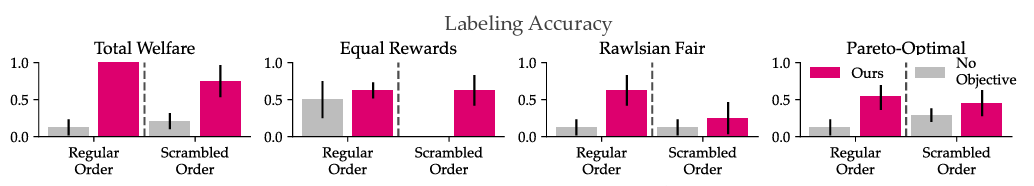

В целом значения в нашем эксперименте на русских данных получаются хуже во всех случаях, но общая закономерность та же. Возможно, дело в том, что дипсик был непоследователен в ответах: например, он мог ответить [3, 3], повторив два значения, чего не может быть.

При этом Rawlsian Fair и Pareto-Optimal больше похожи на данные статьи, в других же случаях отклонения достаточно видимые.

Дальше идёт неизменённый код из гитхаба авторов статьи.

Сначала мы создаём среду для матричных игр, затем определяем функцию для обучения с подкреплением.

В конце определяем функцию main, в которой проходимся по всем комбинациям игр и концептов, обучаем модель, получаем от неё предсказание. Если предсказание правильное (есть в ответах), то мы считаем, что награда равна 1, иначе -- 0. В конце считаем среднее и стандартное отклонение от наград: это значения RL Agent Accuracy.

In [ ]:
class Matrix(gym.Env):
    """Environment for Matrix Games."""

    def __init__(self, model, game, sol_concept,
                 rl_rewards=rl_rewards,
                 deepseek_rewards=deepseek_rewards,
                 blank_rewards=blank_rewards,
                 random_rewards=random_rewards):
        super(Matrix, self).__init__()
        self.action_space = spaces.Discrete(4)  # 0->CC, 1-> CD, 2->DC, 3->DD
        self.observation_space = spaces.Discrete(1)
        self.correct_answers = rl_rewards[(game, sol_concept)]
        if model == "rl":
            self.answers = rl_rewards[(game, sol_concept)]
        elif model == "deepseek":
            self.answers = deepseek_rewards[(game, sol_concept)]
        elif model == "random":
            self.answers = random_rewards[(game, sol_concept)]
        elif model == "blank":
            self.answers = blank_rewards[(game, sol_concept)]
        else:
            raise ValueError
        # self.correct_answers = self.correct_answers[(game, sol_concept)]

    def reset(self):
        return np.array([0])

    def step(self, action):
        done = True
        if action in self.answers:
            reward = 1
        else:
            reward = 0
        next_obs = np.array([0])
        info = {}
        return next_obs, reward, done, info

In [ ]:
def train(model, game, sol_concept, seed):
    env = Matrix(model, game, sol_concept)
    model = DQN(
        "MlpPolicy",
        env,
        verbose=0,
        seed=seed,
        train_freq=2,
        learning_starts=20,
        exploration_fraction=0.5,
        learning_rate=0.0001,
    ).learn(500)
    return model

In [ ]:
def main(model_type):
    data2 = {}
    for sol_concept in ["welfare", "equality", "fairness", "optimality"]:
        data = {}
        for game in ["battle", "dilemma", "hunt", "chicken"]:
            rewards = []
            for seed in range(3):
                model = train(model_type, game, sol_concept, seed)
                test_env = Matrix(model_type, game, sol_concept)
                obs = test_env.reset()
                model.set_env(test_env)
                action, _ = model.predict(obs, deterministic=True)
                if action in test_env.correct_answers:
                    reward = 1
                else:
                    reward = 0
                rewards.append(reward)
            mean, std = np.mean(rewards), np.std(rewards)
            data[game] = (mean, std)
        means, stds = [], []
        for game in data:
            means.append(data[game][0])
            stds.append(data[game][1])
        print(
            f"{sol_concept}!! mean over games: ",
            np.mean(means),
            "stds over games: ",
            np.mean(stds),
        )
        data2[sol_concept] = (np.mean(means), np.mean(stds))
    print(data2)

In [ ]:
RUN_ALL = True

if RUN_ALL:

    for model in ["deepseek", "rl", "blank"]:
        print(f"\n{'='*60}")
        print(f"▶ Комбинация: model={model}")
        print(f"{'='*60}")

        main(model)


▶ Комбинация: model=deepseek
welfare!! mean over games:  0.5 stds over games:  0.0
equality!! mean over games:  0.75 stds over games:  0.23570226039551584
fairness!! mean over games:  0.5 stds over games:  0.0
optimality!! mean over games:  0.5833333333333333 stds over games:  0.11785113019775792
{'welfare': (np.float64(0.5), np.float64(0.0)), 'equality': (np.float64(0.75), np.float64(0.23570226039551584)), 'fairness': (np.float64(0.5), np.float64(0.0)), 'optimality': (np.float64(0.5833333333333333), np.float64(0.11785113019775792))}

▶ Комбинация: model=rl
welfare!! mean over games:  1.0 stds over games:  0.0
equality!! mean over games:  1.0 stds over games:  0.0
fairness!! mean over games:  1.0 stds over games:  0.0
optimality!! mean over games:  1.0 stds over games:  0.0
{'welfare': (np.float64(1.0), np.float64(0.0)), 'equality': (np.float64(1.0), np.float64(0.0)), 'fairness': (np.float64(1.0), np.float64(0.0)), 'optimality': (np.float64(1.0), np.float64(0.0))}

▶ Комбинация: model

Визуализация, чтобы лучше сравнить результаты:

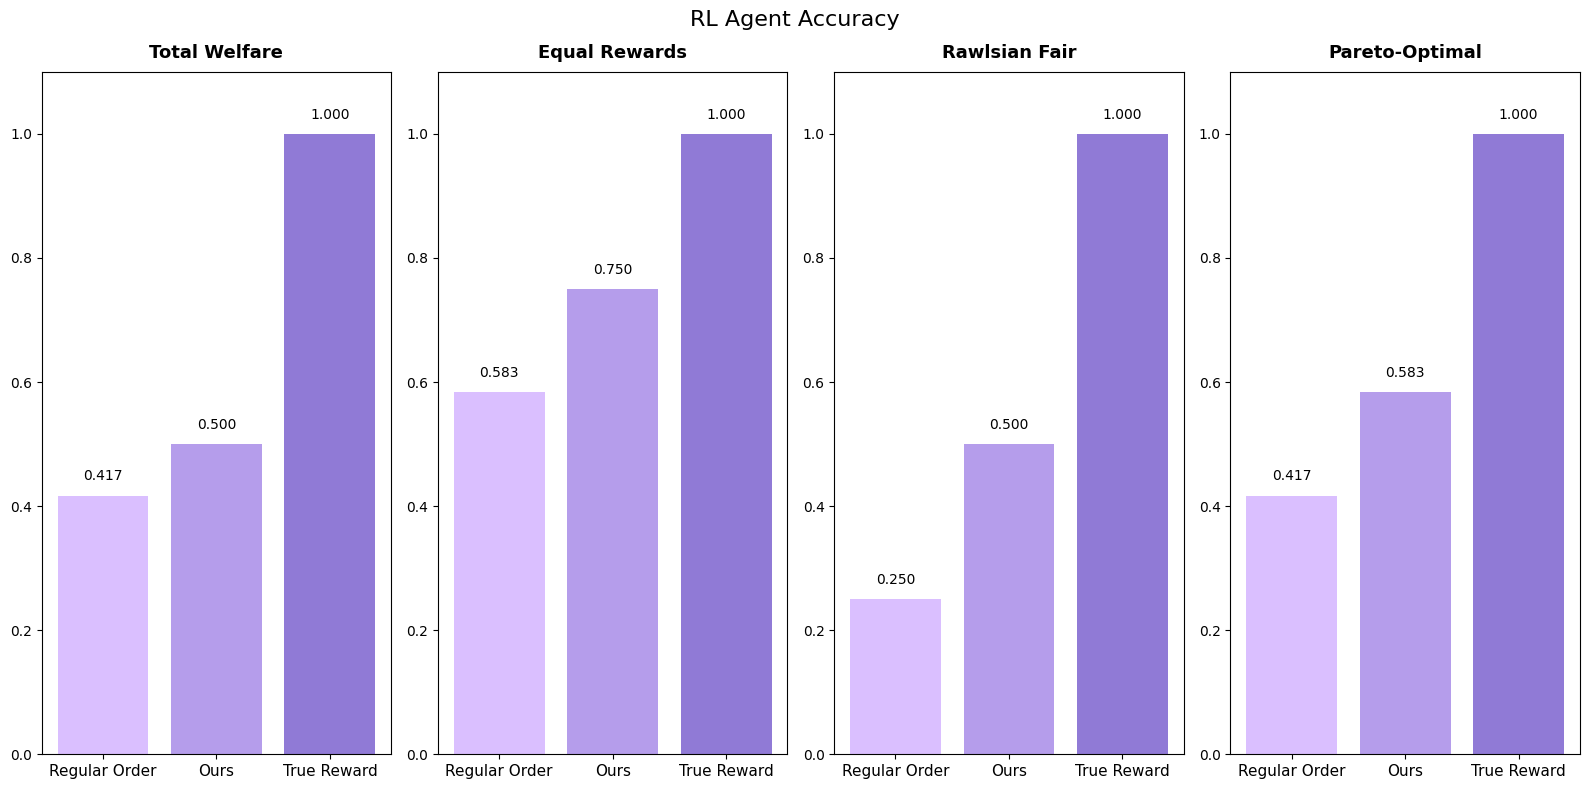

In [ ]:
deepseek_res = {
    'welfare': {'mean': 0.5, 'std': 0.0},
    'equality': {'mean': 0.75, 'std': 0.23570226039551584},
    'fairness': {'mean': 0.5, 'std': 0.0},
    'optimality': {'mean': 0.5833333333333333, 'std': 0.11785113019775792}
}

no_objective_res = {
    'welfare': {'mean': 0.41666666666666663, 'std': 0.11785113019775792},
    'equality': {'mean': 0.5833333333333334, 'std': 0.11785113019775792},
    'fairness': {'mean': 0.25, 'std': 0.0},
    'optimality': {'mean': 0.41666666666666663, 'std': 0.11785113019775792}
}

rl_res = {
    'welfare': {'mean': 1.0, 'std': 0.0},
    'equality': {'mean': 1.0, 'std': 0.0},
    'fairness': {'mean': 1.0, 'std': 0.0},
    'optimality': {'mean': 1.0, 'std': 0.0}
}


fig, axes = plt.subplots(1, 4, figsize=(16, 8))
fig.suptitle('RL Agent Accuracy', fontsize=16)

titles = ['Total Welfare', 'Equal Rewards', 'Rawlsian Fair', 'Pareto-Optimal']
subplot_keys = ['welfare', 'equality', 'fairness', 'optimality']

color1 = '#DABFFF'
color2 = '#B59DEB'
color3 = '#907AD6'

# проходим по всем подграфикам
for idx, (ax, title, key) in enumerate(zip(axes.flat, titles, subplot_keys)):
    # данные для текущего подграфика
    mean2 = deepseek_res[key]['mean']
    mean1 = no_objective_res[key]['mean']
    mean3 = rl_res[key]['mean']

    # создаем столбцы
    x_pos = [0, 1, 2]
    means = [mean1, mean2, mean3]

    # рисуем их
    bars = ax.bar(x_pos, means, color=[color1, color2, color3])

    # добавлем надписи на ось x
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Regular Order', 'Ours', 'True Reward'], fontsize=11)

    # устанавливаем пределы по у, от 0 до 1
    ax.set_ylim(0, 1.1)

    # добавляем заголовок
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)

    # добавляем значения accuracy на график
    for i, (bar, mean_val) in enumerate(zip(bars, means)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.show()

Сравним результаты с теми, что были получены авторами статьи:

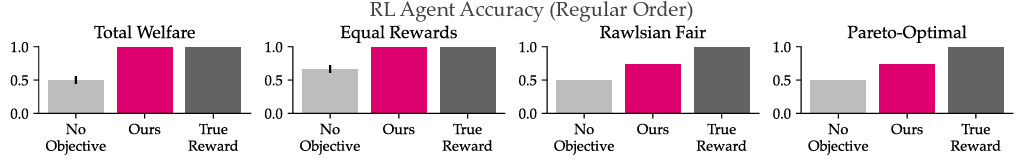

Очевидно, что для model=rl везде accuracy будет 1, потому что это и есть правильные ответы.

Теперь посмотрим на model=blank (то есть No Objective). Наши значения приблизительно равны значениям из статьи: все они около 0.5, причем для equality значение наибольшее. Разве только можно отметить, что fairness у нас почему-то хуже всего.

Теперь дипсик. У авторов статьи значения для welfare и equality равны одному, у нас результаты хуже: всего 0.5 для welfare и 0.75 (правда с std 0.23) для equality. Результаты для fairness и optimality больше приближены к результатам в статье. Вероятнее всего, снова роль играет тот формат, в котором дипсик выдаёт ответы: почему [3, 3]? Возможно, вместо одной из троек он хотел бы дать другой ответ, который и был бы правильным.

В целом всё равно no objective хуже, и на наших данных это тоже видно.

### Ультиматум

Сначала посмотрим на бейзлайн (SL).

#### BASELINE (SL)

##### normal

То есть даём модели на вход 10 примеров.

Здесь идёт код из гитхаба авторов статьи, без изменений.

Определяем модель для бейзлайна: MLP;

определяем функцию для подсчёта labeling accuracy;

определяем функцию для оценки модели, которая возвращает средний лосс по эпохам, среднее и стандартное отклонение для accuracy, а также ответ модели для его сохранения;

определяем функцию для обучения модели: всё стандартно при обучении, считаем лосс, делаем backward, шаг оптимизатора и т.д.;

и определяем функцию main: объединяем предыдущии функции, обучаем модель, выдаём лосс и accuracy.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 32)
        self.hidden_fc = nn.Linear(32, 32)
        self.output_fc = nn.Linear(32, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = []
    epoch_acc = []
    to_save = []

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = torch.tensor([x]).float()
            y_pred = model(x)
            save_lst = x[0].tolist() + [np.argmax(y_pred[0].tolist())]
            to_save.append(save_lst)
            loss = criterion(y_pred, y.long())
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += [loss.item()]
            epoch_acc += [acc.item()]

    assert len(to_save) == 50
    return np.mean(epoch_loss), np.mean(epoch_acc), np.std(epoch_acc), to_save

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = torch.tensor([x]).float()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y.long())
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def main(train_iterator, test_iterator):
    INPUT_DIM = 2
    OUTPUT_DIM = 2
    model = MLP(INPUT_DIM, OUTPUT_DIM)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    EPOCHS = 5
    best_valid_loss = float('inf')
    best_to_save = []
    best_valid_acc_std = None
    best_train_acc = 0
    for epoch in trange(EPOCHS):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, valid_acc_std, to_save = evaluate(model, test_iterator, criterion)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_to_save = to_save
            best_train_acc = train_acc
            best_valid_acc_std = (valid_acc, valid_acc_std)
            print("best!")

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. Std {valid_acc_std}')

    print(f'\t Val. Loss: {best_valid_loss:.3f} |  Val. Acc: {best_valid_acc_std[0]} | Val. Std {best_valid_acc_std[1]} | Train Acc: {best_train_acc:.3f}')
    return np.array(to_save)

In [ ]:
# параметры, с которым мы экспериментируем:
# условие и порог
con_th = {
    "percentages": (0.3, 0.6),
    "payoff": (10, 100)
}

In [ ]:
# сюда будем сохранять ответы модели
os.makedirs('sl_responses', exist_ok=True)

In [ ]:
# проходимся по всем комбинациям параметров
for condition, thresholds in con_th.items():
    for threshold in thresholds:
        print(f'CONDITION: {condition}. THRESHOLD: {threshold}:')
        # дальше неизмененный код из гитхаба

        # загружаем данные
        with open(f"data/{condition}_{threshold}.pkl", "rb") as f:
                pkldata = pkl.load(f)
                train_data, test_data = np.array(pkldata["train"]), np.array(pkldata["test"])

        seed = 0
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

        # normalize
        shifted_train_data = np.copy(train_data)
        shifted_train_data[:,:2] -= np.mean(train_data[:,:2],axis=0)
        shifted_train_data[:,:2] /= np.std(train_data[:,:2],axis=0)


        shifted_test_data = np.copy(test_data)
        shifted_test_data[:,:2] -= np.mean(test_data[:,:2],axis=0)
        shifted_test_data[:,:2] /= np.std(test_data[:,:2],axis=0)
        save_shifted_test_data = np.copy(shifted_test_data) # for debugging purposes

        shifted_train_data = [[[x[0], x[1]], x[2]] for x in shifted_train_data]
        shifted_test_data = [[[x[0], x[1]], x[2]] for x in shifted_test_data]


        train_iterator = data.DataLoader(shifted_train_data,
                                        shuffle=True,
                                        batch_size=1)
        test_iterator = data.DataLoader(shifted_test_data,
                                        shuffle=False,
                                        batch_size=1)

        to_save = main(train_iterator, test_iterator)
        predicted_labels = to_save[:, 2]

        # # assert that test data loader did not shuffle the test batch
        assert (np.all(np.around(to_save[:, :2],3) == np.around(save_shifted_test_data[:, :2],3)))
        sl_labeled_test_data = np.copy(test_data)
        correct_labels = np.copy(sl_labeled_test_data[:, 2])
        sl_labeled_test_data[:,2] = predicted_labels
        print(np.all(correct_labels == predicted_labels))
        print('='*50)

        # сохраняем данные в файл
        with open(f"sl_responses/{condition}_{threshold}_train.pkl", "wb") as f:
            pkl.dump({'test':sl_labeled_test_data}, f)

CONDITION: percentages. THRESHOLD: 0.3:


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 0.638 | Train Acc: 90.00%
	 Val. Loss: 0.688 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 02
	Train Loss: 0.544 | Train Acc: 100.00%
	 Val. Loss: 0.667 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 03
	Train Loss: 0.452 | Train Acc: 100.00%
	 Val. Loss: 0.659 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 04
	Train Loss: 0.364 | Train Acc: 100.00%
	 Val. Loss: 0.655 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.277 | Train Acc: 100.00%
	 Val. Loss: 0.688 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.203 | Train Acc: 100.00%
	 Val. Loss: 0.738 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.144 | Train Acc: 100.00%
	 Val. Loss: 0.818 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.101 | Train Acc: 100.00%
	 Val. Loss: 0.900 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.072 | Train Acc: 100.00%
	 Val. Loss: 0.990 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.052 | Train Acc: 100.00%
	 Val. Loss: 1.076 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405
False
CONDITION: percentages. THRESHOLD: 0.6:


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 0.692 | Train Acc: 60.00%
	 Val. Loss: 0.712 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 02
	Train Loss: 0.631 | Train Acc: 70.00%
	 Val. Loss: 0.692 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 03
	Train Loss: 0.576 | Train Acc: 90.00%
	 Val. Loss: 0.676 |  Val. Acc: 50.00% | Val. Std 0.5


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 04
	Train Loss: 0.523 | Train Acc: 90.00%
	 Val. Loss: 0.672 |  Val. Acc: 50.00% | Val. Std 0.5


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 05
	Train Loss: 0.471 | Train Acc: 100.00%
	 Val. Loss: 0.664 |  Val. Acc: 54.00% | Val. Std 0.49839743177508455


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 06
	Train Loss: 0.423 | Train Acc: 100.00%
	 Val. Loss: 0.659 |  Val. Acc: 56.00% | Val. Std 0.4963869458396342


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 07
	Train Loss: 0.375 | Train Acc: 100.00%
	 Val. Loss: 0.652 |  Val. Acc: 58.00% | Val. Std 0.4935585071701226


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.329 | Train Acc: 100.00%
	 Val. Loss: 0.654 |  Val. Acc: 58.00% | Val. Std 0.4935585071701226


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.286 | Train Acc: 100.00%
	 Val. Loss: 0.659 |  Val. Acc: 60.00% | Val. Std 0.48989794855663565


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.245 | Train Acc: 100.00%
	 Val. Loss: 0.671 |  Val. Acc: 60.00% | Val. Std 0.48989794855663565
False
CONDITION: payoff. THRESHOLD: 10:


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 0.717 | Train Acc: 40.00%
	 Val. Loss: 0.683 |  Val. Acc: 66.00% | Val. Std 0.4737087712930804


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 02
	Train Loss: 0.658 | Train Acc: 80.00%
	 Val. Loss: 0.650 |  Val. Acc: 68.00% | Val. Std 0.466476151587624


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 03
	Train Loss: 0.614 | Train Acc: 80.00%
	 Val. Loss: 0.620 |  Val. Acc: 72.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 04
	Train Loss: 0.570 | Train Acc: 90.00%
	 Val. Loss: 0.599 |  Val. Acc: 72.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 05
	Train Loss: 0.535 | Train Acc: 90.00%
	 Val. Loss: 0.577 |  Val. Acc: 72.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 06
	Train Loss: 0.496 | Train Acc: 90.00%
	 Val. Loss: 0.559 |  Val. Acc: 72.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 07
	Train Loss: 0.462 | Train Acc: 90.00%
	 Val. Loss: 0.541 |  Val. Acc: 72.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 08
	Train Loss: 0.434 | Train Acc: 90.00%
	 Val. Loss: 0.525 |  Val. Acc: 72.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 09
	Train Loss: 0.403 | Train Acc: 90.00%
	 Val. Loss: 0.512 |  Val. Acc: 72.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 10
	Train Loss: 0.379 | Train Acc: 90.00%
	 Val. Loss: 0.504 |  Val. Acc: 72.00% | Val. Std 0.448998886412873
False
CONDITION: payoff. THRESHOLD: 100:


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 0.722 | Train Acc: 20.00%
	 Val. Loss: 0.675 |  Val. Acc: 90.00% | Val. Std 0.3


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 02
	Train Loss: 0.641 | Train Acc: 90.00%
	 Val. Loss: 0.611 |  Val. Acc: 92.00% | Val. Std 0.2712931993250107


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 03
	Train Loss: 0.575 | Train Acc: 100.00%
	 Val. Loss: 0.554 |  Val. Acc: 94.00% | Val. Std 0.23748684174075838


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 04
	Train Loss: 0.514 | Train Acc: 100.00%
	 Val. Loss: 0.500 |  Val. Acc: 90.00% | Val. Std 0.3


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 05
	Train Loss: 0.452 | Train Acc: 100.00%
	 Val. Loss: 0.448 |  Val. Acc: 90.00% | Val. Std 0.3


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 06
	Train Loss: 0.389 | Train Acc: 100.00%
	 Val. Loss: 0.398 |  Val. Acc: 90.00% | Val. Std 0.3


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 07
	Train Loss: 0.334 | Train Acc: 100.00%
	 Val. Loss: 0.351 |  Val. Acc: 90.00% | Val. Std 0.3


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 08
	Train Loss: 0.278 | Train Acc: 100.00%
	 Val. Loss: 0.307 |  Val. Acc: 90.00% | Val. Std 0.3


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 09
	Train Loss: 0.228 | Train Acc: 100.00%
	 Val. Loss: 0.269 |  Val. Acc: 92.00% | Val. Std 0.2712931993250107


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 10
	Train Loss: 0.185 | Train Acc: 100.00%
	 Val. Loss: 0.239 |  Val. Acc: 92.00% | Val. Std 0.2712931993250107
False


Сравним с тем, что получилось в статье.

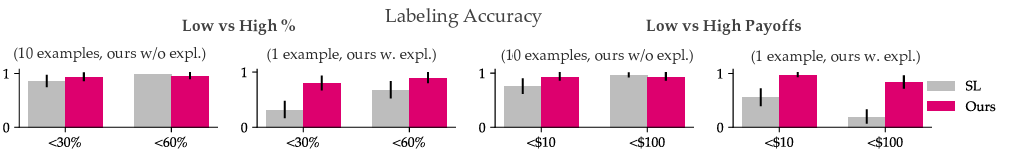

Для первого случая (percentages, 0.3) у нас получилась accuracy = 0.7, а std = 0.46. По графику не очень понятно, какая именно была accuracy у авторов статьи, но в целом видно, что значение больше 0.5 и меньше 1 (возможно, чуть ближе к одному). Тогда результаты можно назвать сопоставимыми.

Для percentages 0.6 у нас accuracy чуть ниже (0.6), зато стандартное отклонение чуть выше: 0.49. У авторов статьи, кажется, идеальная accuracy (даже больше, чем у llm!) Здесь расхождение достаточно заметное.

Далее, для payoff, 10: У нас 0.72, что очень похоже на результаты на графике.

И, наконец, для payoff 100: у нас 0.92, что также очень близко к результатам на графике.

В целом везде результаты сопоставимы, но у нас меньше accuracy для percentages, 0.6: у авторов статьи удивительным образом получается 1!

##### shorter

То есть даём модели на вход один пример.

Здесь также беру код из гитхаба. В целом структура кода та же, меняется только train_data при запуске: мы берём только один пример, а не 10 (и так как мы делим 100 рублей, а не 10 долларов, умножаем на 10: вместо 9.78 у нас 97.8, например).

In [ ]:
def main(train_iterator, test_iterator):
    INPUT_DIM = 2
    OUTPUT_DIM = 2
    model = MLP(INPUT_DIM, OUTPUT_DIM)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    EPOCHS = 10
    best_valid_loss = float('inf')
    best_to_save = []
    best_valid_acc_std = None
    best_train_acc = 0
    for epoch in trange(EPOCHS):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, valid_acc_std, to_save = evaluate(model, test_iterator, criterion)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_to_save = to_save
            best_train_acc = train_acc
            best_valid_acc_std = (valid_acc, valid_acc_std)
            print("best!")

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. Std {valid_acc_std}')

    # print(f'\t Val. Loss: {best_valid_loss:.3f} |  Val. Acc: {best_valid_acc_std[0]} | Val. Std {best_valid_acc_std[1]} | Train Acc: {best_train_acc:.3f}')
    return np.array(to_save)

In [ ]:
os.makedirs('sl_responses_shorter', exist_ok=True)

In [ ]:
for condition, thresholds in con_th.items():
    for threshold in thresholds:
        print(f'CONDITION: {condition}. THRESHOLD: {threshold}:')
        with open(f"data/{condition}_{threshold}.pkl", "rb") as f:
                pkldata = pkl.load(f)
                train_data, test_data = np.array(pkldata["train"]), np.array(pkldata["test"])

        # так как у нас только один пример, а не 10, переопределяем train_data
        if threshold == 0.3 and condition == 'percentages':
            train_data = np.array([[97.8, 2.2, 0.]])
        elif threshold == 0.6 and condition == 'percentages':
            train_data = np.array([[47.1, 52.9, 0.]])
        elif threshold == 10 and condition == 'payoff':
            train_data = np.array([[54, 46, 0.]])
        elif threshold == 100 and condition == 'payoff':
            train_data = np.array([[700, 300, 1.]])

        seed = 0
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

        # normalize
        shifted_train_data = np.copy(train_data)
        shifted_train_data[:,:2] -= np.mean(train_data[:,:2],axis=0)
        shifted_train_data[:,:2] /= np.std(train_data[:,:2],axis=0)


        shifted_train_data = np.copy(train_data)
        shifted_test_data = np.copy(test_data)
        save_shifted_test_data = np.copy(shifted_test_data) # for debugging purposes
        shifted_train_data = [[[x[0], x[1]], x[2]] for x in shifted_train_data]
        shifted_test_data = [[[x[0], x[1]], x[2]] for x in shifted_test_data]


        train_iterator = data.DataLoader(shifted_train_data,
                                        shuffle=True,
                                        batch_size=1)
        test_iterator = data.DataLoader(shifted_test_data,
                                        shuffle=False,
                                        batch_size=1)

        to_save = main(train_iterator, test_iterator)
        predicted_labels = to_save[:, 2]

        # # assert that test data loader did not shuffle the test batch
        assert (np.all(np.around(to_save[:, :2],3) == np.around(save_shifted_test_data[:, :2],3)))
        sl_labeled_test_data = np.copy(test_data)
        correct_labels = np.copy(sl_labeled_test_data[:, 2])
        sl_labeled_test_data[:,2] = predicted_labels
        print(np.all(correct_labels == predicted_labels))
        print('='*50)

        with open(f"sl_responses_shorter/{condition}_{threshold}_train.pkl", "wb") as f:
            pkl.dump({'test':sl_labeled_test_data}, f)

CONDITION: percentages. THRESHOLD: 0.3:


/tmp/ipython-input-336728627.py:27: RuntimeWarning: invalid value encountered in divide
  shifted_train_data[:,:2] /= np.std(train_data[:,:2],axis=0)


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 8.236 | Train Acc: 0.00%
	 Val. Loss: 1.994 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 02
	Train Loss: 7.448 | Train Acc: 0.00%
	 Val. Loss: 1.806 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 03
	Train Loss: 6.752 | Train Acc: 0.00%
	 Val. Loss: 1.632 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 04
	Train Loss: 6.065 | Train Acc: 0.00%
	 Val. Loss: 1.472 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 05
	Train Loss: 5.388 | Train Acc: 0.00%
	 Val. Loss: 1.326 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 06
	Train Loss: 4.722 | Train Acc: 0.00%
	 Val. Loss: 1.196 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 07
	Train Loss: 4.068 | Train Acc: 0.00%
	 Val. Loss: 1.085 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 08
	Train Loss: 3.431 | Train Acc: 0.00%
	 Val. Loss: 0.999 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 09
	Train Loss: 2.815 | Train Acc: 0.00%
	 Val. Loss: 0.944 |  Val. Acc: 70.00% | Val. Std 0.45825756949558405


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 10
	Train Loss: 2.231 | Train Acc: 0.00%
	 Val. Loss: 0.922 |  Val. Acc: 12.00% | Val. Std 0.32496153618543844
False
CONDITION: percentages. THRESHOLD: 0.6:


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 3.460 | Train Acc: 0.00%
	 Val. Loss: 3.745 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 02
	Train Loss: 2.736 | Train Acc: 0.00%
	 Val. Loss: 3.338 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 03
	Train Loss: 2.064 | Train Acc: 0.00%
	 Val. Loss: 2.974 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 04
	Train Loss: 1.466 | Train Acc: 0.00%
	 Val. Loss: 2.676 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 05
	Train Loss: 0.976 | Train Acc: 0.00%
	 Val. Loss: 2.451 |  Val. Acc: 8.00% | Val. Std 0.2712931993250107


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 06
	Train Loss: 0.668 | Train Acc: 100.00%
	 Val. Loss: 2.298 |  Val. Acc: 10.00% | Val. Std 0.3


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 07
	Train Loss: 0.457 | Train Acc: 100.00%
	 Val. Loss: 2.201 |  Val. Acc: 16.00% | Val. Std 0.36660605559646714


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 08
	Train Loss: 0.308 | Train Acc: 100.00%
	 Val. Loss: 2.147 |  Val. Acc: 18.00% | Val. Std 0.38418745424597095


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 09
	Train Loss: 0.208 | Train Acc: 100.00%
	 Val. Loss: 2.113 |  Val. Acc: 24.00% | Val. Std 0.4270831300812525


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 10
	Train Loss: 0.142 | Train Acc: 100.00%
	 Val. Loss: 2.097 |  Val. Acc: 28.00% | Val. Std 0.44899888641287294
False
CONDITION: payoff. THRESHOLD: 10:


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 4.190 | Train Acc: 0.00%
	 Val. Loss: 6.880 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 02
	Train Loss: 3.513 | Train Acc: 0.00%
	 Val. Loss: 6.648 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 03
	Train Loss: 2.859 | Train Acc: 0.00%
	 Val. Loss: 6.434 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 04
	Train Loss: 2.240 | Train Acc: 0.00%
	 Val. Loss: 6.231 |  Val. Acc: 28.00% | Val. Std 0.448998886412873


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 05
	Train Loss: 1.672 | Train Acc: 0.00%
	 Val. Loss: 6.034 |  Val. Acc: 22.00% | Val. Std 0.41424630354415964


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 06
	Train Loss: 1.180 | Train Acc: 0.00%
	 Val. Loss: 5.870 |  Val. Acc: 14.00% | Val. Std 0.3469870314579494


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 07
	Train Loss: 0.786 | Train Acc: 0.00%
	 Val. Loss: 5.740 |  Val. Acc: 12.00% | Val. Std 0.32496153618543844


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 08
	Train Loss: 0.502 | Train Acc: 100.00%
	 Val. Loss: 5.637 |  Val. Acc: 10.00% | Val. Std 0.3


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 09
	Train Loss: 0.313 | Train Acc: 100.00%
	 Val. Loss: 5.557 |  Val. Acc: 8.00% | Val. Std 0.2712931993250107


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 10
	Train Loss: 0.194 | Train Acc: 100.00%
	 Val. Loss: 5.499 |  Val. Acc: 8.00% | Val. Std 0.2712931993250107
False
CONDITION: payoff. THRESHOLD: 100:


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

best!
Epoch: 01
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 12.608 |  Val. Acc: 2.00% | Val. Std 0.13999999999999999
False


Снова сравним с тем, что было в статье:

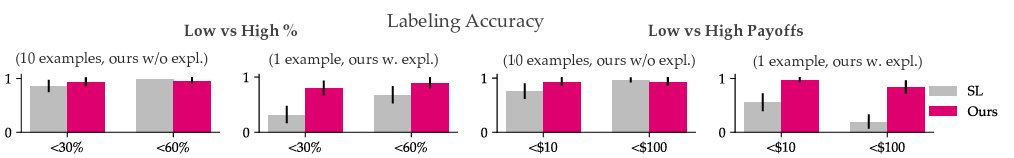

Интересно, что для percentages 0.3 accuracy на валидации почти всё время была 70, а на последней эпохе стала всего 12( Но в целом значение достаточно низкое, что совпадает с результатами из статьи (у них, может, чуть выше).

Для percentages 0.6 у нас снова гораздо хуже, чем в статье: всего 0.28, а у них явно больше 0.5.

Для payoff, кстати, тоже видно переобучение / обучение не туда: вначале accuracy была выше, а сошлись мы на 0.08( Это, конечно, гораздо меньше, чем в статье.

А для payoff 100, у нас, как и у авторов статьи, очень маленький скор, но у нас всё же, скорее всего, чуть меньше: 0.02.

Возможно, разница в результатах объясняется тем, что мы делим 100 рублей, а не 10 долларов, это более большие числа, и модель с ними справляется чуть хуже.

#### LLM

В этой части кода мы оцениваем ответы LLM и обучаем RL агента, чтобы оценить RL Agent Acuracy как для языковой модели, так и для бейзлайна.

Класс для игры ультиматум, функция train и train_Rl полностью взяты из гитхаба авторов статьи.

In [ ]:
class Ultimatum(gym.Env):
    """Environment for Ultimatum Game."""

    def __init__(self, path):
        super(Ultimatum, self).__init__()
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0.0, high=10.0, shape=(2,))
        with open(path, "rb") as f:
            data = pkl.load(f)
            self.test_set = data["test"]

    def reset(self):
        # randomly sample from test set
        idx = np.random.choice(range(len(self.test_set)))
        self.obs = self.test_set[idx][:-1]
        self.label = self.test_set[idx][-1]
        return self.obs

    def step(self, action):
        done = True
        reward = int(self.label == action)
        next_obs = np.array([0, 0])
        info = {}
        return next_obs, reward, done, info

In [ ]:
def train(train_path, seed):
    env = Ultimatum(train_path)
    model = DQN(
        "MlpPolicy",
        env,
        verbose=0,  # поменяла, чтобы не выводилось лишнего
        seed=seed,
        train_freq=2,
        learning_starts=20,
        exploration_fraction=0.5,
        learning_rate=0.0001,
    ).learn(10000)
    return model

In [ ]:
def train_RL(train_path, test_path, seed=0):
    model = train(train_path, seed)
    test_env = Ultimatum(test_path)
    obs = test_env.reset()
    model.set_env(test_env)
    rewards = []
    for i, datum in enumerate(test_env.test_set):
        obs = np.array(datum[:-1])
        test_env.obs = datum[:-1]
        test_env.label = datum[-1]
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = test_env.step(action)
        # print("Step {}".format(i), "Action: ", action, "Obs: ", datum, "reward: ", reward)
        rewards.append(reward)
        # if reward == 0:
        #     print(datum, action)
    # print(f"mean correct: {np.mean(rewards)}, std: {np.around(np.std(rewards),2)}")
    return np.mean(rewards), np.std(rewards)

Следующие две функции немного поменяла: убрала лишнее (например, выделение денег из промпта: у нас нет значков долларов, поэтому там немного сложнее, но на ответ это в целом не влияет), а также изменила конвертирование ответов модели: дипсик не всегда отвечал только Да или Нет, поэтому я смотрела на наличие этих ключей в его ответе, и уже в соответствии с этим привожу ответ к 1 или 0.

In [ ]:
def evaluate_lm_responses(path):
    '''
    Функция для оценки ответов llm.
    Принимает на вход:
        path: путь до файла .pkl с ответами модели.
    Возвращает:
        среднее значение accuracy,
        стандартное отклонение accuracy.
    '''

    with open(f"data/{path}.pkl", "rb") as f:
        ground_truth = pkl.load(f)["test"]
    with open(f"llm_responses/{path}.pkl", "rb") as f:
        lm_responses = pkl.load(f)

    is_desirable_text2int = {"Да": 0, "Нет": 1}
    lm_correct = []
    to_save = []
    for i, datum in enumerate(lm_responses):
        lm_response = datum[1].strip()
        for key in is_desirable_text2int.keys():
            if key in str(lm_response):
                lm_response = is_desirable_text2int[key]
        lm_correct.append(int(lm_response == ground_truth[i][-1]))
        to_save.append([ground_truth[i][0], ground_truth[i][1], lm_response])
    with open(f"llm_responses/{path}_train.pkl", "wb") as f:
       to_save = {"test": to_save}
       pkl.dump(to_save, f)
    print(
        "mean correct ", np.mean(lm_correct), "std: ", np.around(np.std(lm_correct), 2)
    )

In [ ]:
def evaluate_lm_responses_shorter(path):
    '''
    Функция для оценки ответом llm, когда промпт содержит только один пример.
    Принимает на вход:
        path: путь до файла .pkl с ответами модели.
    Возвращает:
        среднее значение accuracy,
        стандартное отклонение accuracy.
    '''

    with open(f"data/{path}.pkl", "rb") as f:
        ground_truth = pkl.load(f)["test"]
    with open(f"llm_responses_shorter/{path}.pkl", "rb") as f:
        lm_responses = pkl.load(f)

    is_desirable_text2int = {"Да": 0, "Нет": 1}
    lm_correct = []
    to_save = []
    for i, datum in enumerate(lm_responses):
        lm_response = datum[1].strip()
        for key in is_desirable_text2int.keys():
            if key in str(lm_response):
                lm_response = is_desirable_text2int[key]
        lm_correct.append(int(lm_response == ground_truth[i][-1]))
        to_save.append([ground_truth[i][0], ground_truth[i][1], lm_response])
    with open(f"llm_responses_shorter/{path}_train.pkl", "wb") as f:
       to_save = {"test": to_save}
       pkl.dump(to_save, f)
    print(
        "mean correct ", np.mean(lm_correct), "std: ", np.around(np.std(lm_correct), 2)
    )

Функцию main взяла из гитхаба.

В случае, если перед нами llm, оценивает ответы модели (labeling accuracy). Если же бейзлайн, то оцениваем только RL Agent Accuracy (labeling смотрели в предыдущем разделе).

In [ ]:
def main(condition, shorter, num_seeds, model, thresholds):
    for threshold in thresholds:
        print("THRESHOLD: ", threshold)
        partial_path = f"{condition}_{threshold}"
        if model == "deepseek":
            if shorter:
                evaluate_lm_responses_shorter(partial_path)
                model_path = f"llm_responses_shorter/{partial_path}_train.pkl"
            else:
                evaluate_lm_responses(partial_path)
                model_path = f"llm_responses/{partial_path}_train.pkl"
        elif model == "sl":
            if shorter:
                model_path = f"sl_responses_shorter/{partial_path}_train.pkl"
            else:
                model_path = f"sl_responses/{partial_path}_train.pkl"
        path = f"data/{partial_path}.pkl"
        means = []
        stds = []
        for seed in range(num_seeds):
            mean, std = train_RL(train_path=model_path, test_path=path, seed=seed)
            means.append(mean)
            stds.append(std)
        print("mean: ", np.mean(means), "std: ", np.mean(stds))

In [ ]:
# запускаем все комбинации
RUN_ALL = True
NUM_SEEDS = 3

thresholds_by_condition = {
    "percentages": [0.3, 0.6],
    "payoff": [10, 100],
}

if RUN_ALL:
    all_combinations = list(product(
        ["percentages", "payoff"],
        [True, False],
        ["deepseek", "sl"]
    ))

    for condition, shorter, model in all_combinations:
        print(f"\n{'='*60}")
        print(f"▶ Комбинация: condition={condition}, model={model}, shorter={shorter}")
        print(f"{'='*60}")

        main(
            condition,
            shorter,
            NUM_SEEDS,
            model,
            thresholds=thresholds_by_condition[condition],
        )


▶ Комбинация: condition=percentages, model=deepseek, shorter=True
THRESHOLD:  0.3
mean correct  0.4 std:  0.49
mean:  0.4000000000000001 std:  0.48456959043102676
THRESHOLD:  0.6
mean correct  0.4 std:  0.49
mean:  0.34 std:  0.47339497429356814

▶ Комбинация: condition=percentages, model=sl, shorter=True
THRESHOLD:  0.3
mean:  0.12 std:  0.32496153618543844
THRESHOLD:  0.6
mean:  0.28 std:  0.44899888641287294

▶ Комбинация: condition=percentages, model=deepseek, shorter=False
THRESHOLD:  0.3
mean correct  0.3 std:  0.46
mean:  0.28 std:  0.44863023329922774
THRESHOLD:  0.6
mean correct  1.0 std:  0.0
mean:  0.9266666666666666 std:  0.2213958180819903

▶ Комбинация: condition=percentages, model=sl, shorter=False
THRESHOLD:  0.3
mean:  0.6999999999999998 std:  0.458257569495584
THRESHOLD:  0.6
mean:  0.6 std:  0.48989794855663565

▶ Комбинация: condition=payoff, model=deepseek, shorter=True
THRESHOLD:  10
mean correct  0.5 std:  0.5
mean:  0.7333333333333334 std:  0.43849167933349903


Визуализация для Labeling Accuracy для всех данных (SL + Ours):

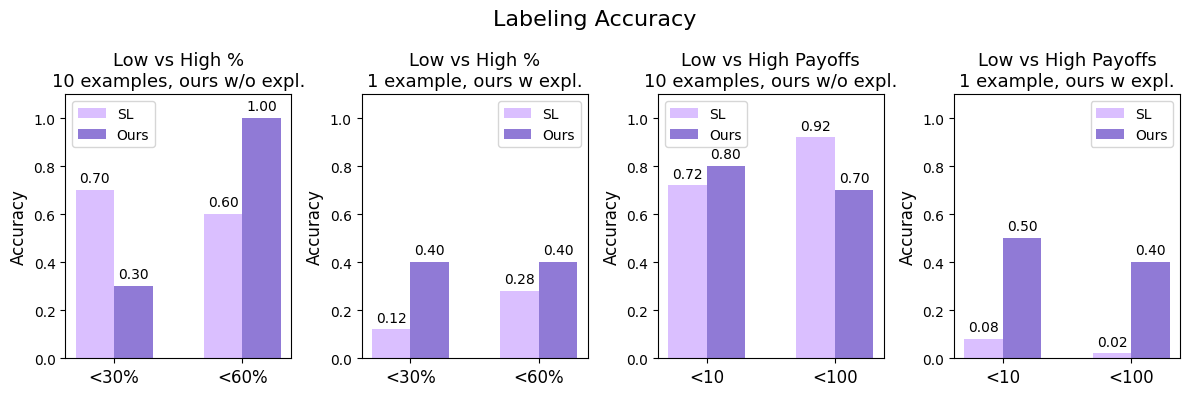

In [ ]:
# данные из экспериментов (это предыдущая часть BASELINE (SL))
SL = {
    'percentages': {
        'normal': {'<30%': 0.7, '<60%': 0.6},
        'shorter':  {'<30%': 0.12, '<60%': 0.28}
    },
    'payoff': {
        'normal': {'<10': 0.72, '<100': 0.92},
        'shorter': {'<10': 0.08, '<100': 0.02}
    }
}

# данные из эксперимента этой части
ours = {
    'percentages': {
        'normal': {'<30%': 0.3, '<60%': 1.0},
        'shorter': {'<30%': 0.4, '<60%': 0.4}
    },
    'payoff': {
        'normal': {'<10': 0.8, '<100': 0.7},
        'shorter': {'<10': 0.5, '<100': 0.4}
    }
}

# создаём четыре подграфика
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Labeling Accuracy', fontsize=16)

# настраиваем графики
configs = [
    (0, 0, 'percentages', 'normal', '10 examples, ours w/o expl.'),
    (0, 1, 'percentages', 'shorter', '1 example, ours w expl.'),
    (0, 2, 'payoff', 'normal', '10 examples, ours w/o expl.'),
    (0, 3, 'payoff', 'shorter', '1 example, ours w expl.')
]

color1 = '#DABFFF'
color2 = '#907AD6'

# проходим по всем подграфикам
for row, col, data_type, example_type, title_suffix in configs:
    ax = axes[col]

    # определяем метки
    if data_type == 'percentages':
        labels = ['<30%', '<60%']
        title_main = 'Low vs High %'
    else:
        labels = ['<10', '<100']
        title_main = 'Low vs High Payoffs'

    # достаём данные из словарей
    sl_values = [SL[data_type][example_type][label] for label in labels]
    ours_values = [ours[data_type][example_type][label] for label in labels]

    # рисуем столбцы
    x = np.arange(len(labels))
    width = 0.3

    bars_sl = ax.bar(x - width/2, sl_values, width, color=color1, label='SL')
    bars_ours = ax.bar(x + width/2, ours_values, width, color=color2, label='Ours')

    # добавляем подписи
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{title_main}\n{title_suffix}', fontsize=13)
    ax.set_ylim(0, 1.1)

    # и значения accuracy над столбцами
    for bars in [bars_sl, bars_ours]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    ax.legend()

plt.tight_layout()
plt.show()

Сравним теперь с labeling accuracy из статьи:
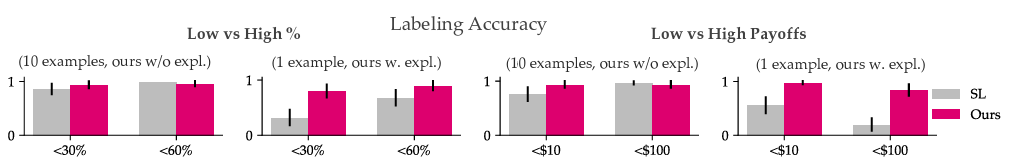

Согласно данным статьи, SL справляется чуть лучше в двух случаях: 10 examples, <60% и тоже 10 examples, <$100. В остальных случаях LLM лучше.

На наших данных немного другое распределение:

с одной стороны, для payoffs <100 у нас также sl лучше (но разница у нас чуть более заметна, чем у авторов статьи), а с другой -- sl лучше в случае percentages <30%, а не 60%, как в статье. Для 60% у нас LLM показывает качество 1 (впрочем, у авторов статьи значение близко к 1).

В остальном закономерности примерно одинаковые, но у нас всегда чуть меньше (или не чуть, как для 1 example, payoff) значения accuracy для LLM. Возможно, дело в том, что мы делим не 10, а 100 рублей (числа больше => модели могут с ними справлять чуть хуже).

Теперь визуализиурем RL Agent Accuracy:

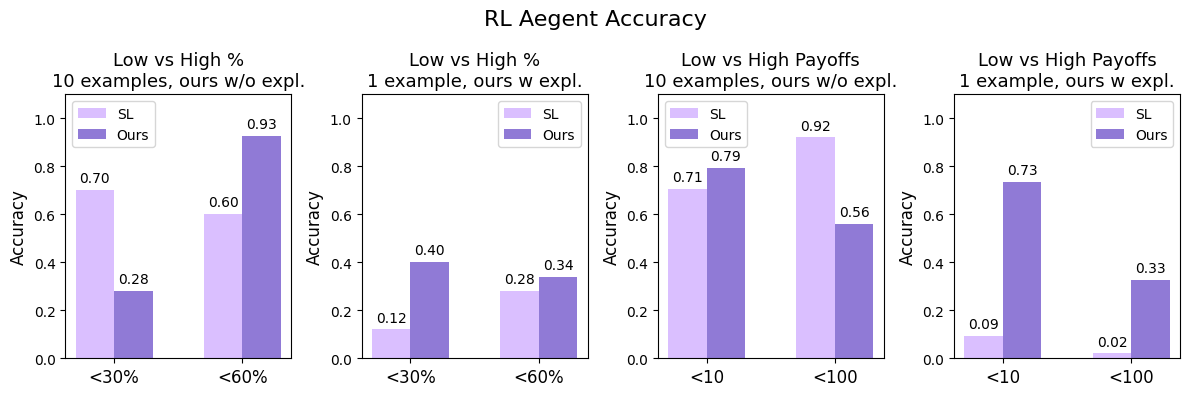

In [ ]:
# данные из экспериментов
SL = {
    'percentages': {
        'normal': {'<30%': 0.6999999999999998, '<60%': 0.6},
        'shorter':  {'<30%': 0.12, '<60%': 0.28}
    },
    'payoff': {
        'normal': {'<10': 0.7066666666666667, '<100': 0.9199999999999999},
        'shorter': {'<10': 0.09333333333333334, '<100': 0.02}
    }
}

ours = {
    'percentages': {
        'normal': {'<30%': 0.28, '<60%': 0.9266666666666666},
        'shorter': {'<30%': 0.4000000000000001, '<60%': 0.34}
    },
    'payoff': {
        'normal': {'<10': 0.7933333333333333, '<100': 0.56},
        'shorter': {'<10': 0.7333333333333334, '<100': 0.32666666666666666}
    }
}

# создаём четыре подграфика
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('RL Aegent Accuracy', fontsize=16)

# настраиваем графики
configs = [
    (0, 0, 'percentages', 'normal', '10 examples, ours w/o expl.'),
    (0, 1, 'percentages', 'shorter', '1 example, ours w expl.'),
    (0, 2, 'payoff', 'normal', '10 examples, ours w/o expl.'),
    (0, 3, 'payoff', 'shorter', '1 example, ours w expl.')
]

color1 = '#DABFFF'
color2 = '#907AD6'

# проходим по всем подграфикам
for row, col, data_type, example_type, title_suffix in configs:
    ax = axes[col]

    # определяем метки
    if data_type == 'percentages':
        labels = ['<30%', '<60%']
        title_main = 'Low vs High %'
    else:
        labels = ['<10', '<100']
        title_main = 'Low vs High Payoffs'

    # достаём данные из словарей
    sl_values = [SL[data_type][example_type][label] for label in labels]
    ours_values = [ours[data_type][example_type][label] for label in labels]

    # рисуем столбцы
    x = np.arange(len(labels))
    width = 0.3

    bars_sl = ax.bar(x - width/2, sl_values, width, color=color1, label='SL')
    bars_ours = ax.bar(x + width/2, ours_values, width, color=color2, label='Ours')

    # добавляем подписи
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{title_main}\n{title_suffix}', fontsize=13)
    ax.set_ylim(0, 1.1)

    # и значения accuracy над столбцами
    for bars in [bars_sl, bars_ours]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    ax.legend()

plt.tight_layout()
plt.show()

Сравним со статьёй:
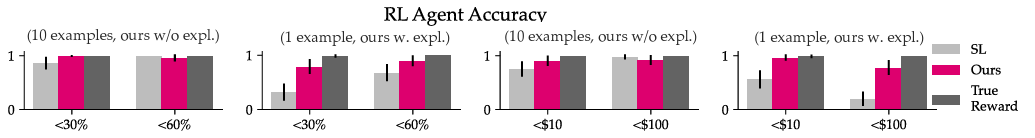

Для всех случаев, кроме low vs high %, 10 examples у нас получились болеем-менее похожие данные, то есть закономерности, но сами значения чуть ниже. Low vs high %, 10 examples показывает совсем плохие данные для LLM при пороге в 30%, гораздо хуже, чем в статье и чем SL. А вот SL у нас справляется гораздо хуже с порогом в 60% при тех же условиях, а LLM достигает почти идеального скора.

Для чистоты можно было бы посмотреть на 10 долларов, но, возможно, из-за русского языка модели было бы чуть сложнее делить такое количество денег (потому что 10 рублей -- это очень мало, а 100 -- более адекватная сумма для русского).

### Переговоры

Здесь мы решили запустить эксперимент на английских, а не русских данных, чтобы не переводить большие текстовые файлы с английского на русский.

Будем запускать код так, как на своём гитхабе указывали авторы статьи: через командную строку. Переписывание функций и вставление их в код немного затруднительно, потому что сложно решаются проблемы с библиотеками самих авторов (код для которых хранится на гитхабе), а запуск через командную строку более интуитивный и компактный.

#### Rl + Sl (baseline)

Мы уже склонировали репозиторий в Части 0, переходим в директорию с нужным заданием.

In [ ]:
%cd /content/reward_design_with_llms/negotiation/

/content/reward_design_with_llms/negotiation


In [ ]:
!pip install certifi==2022.12.7

!grep -v "certifi @" requirements.txt > requirements_clean.txt
!pip install -r requirements_clean.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: certifi
    Found existing installation: certifi 2025.11.12
    Uninstalling certifi-2025.11.12:
      Successfully uninstalled certifi-2025.11.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
curl-cffi 0.13.0 requires certifi>=2024.2.2, but you have certifi 2022.12.7 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/7.3 MB 10.2 MB/s eta 0:00:01
ERROR: Operation cancelled by user
^C


In [ ]:
# запускаем код для обучения бейзлайн модели
!python sl.py

/content/reward_design_with_llms/negotiation/utils/domain.py:82: SyntaxWarning: invalid escape sequence '\-'
  self.item_pattern = re.compile('^item([0-9])=([0-9\-])+$')
dataset data/train.txt, total 242196, unks 12, ratio 0.00%, datapoints 10095
dataset data/val.txt, total 26002, unks 0, ratio 0.00%, datapoints 1087
dataset data/test.txt, total 24992, unks 2, ratio 0.01%, datapoints 1052
| epoch 001 | trainloss 2.826 | trainppl 16.875 | trainacc 0.547 | s/epoch 35.19 | lr 1.00000000
| epoch 001 | validloss 1.856 | validppl 6.396 | validacc 0.596
| epoch 002 | trainloss 2.505 | trainppl 12.241 | trainacc 0.609 | s/epoch 23.19 | lr 1.00000000
| epoch 002 | validloss 1.608 | validppl 4.993 | validacc 0.626
| epoch 003 | trainloss 2.406 | trainppl 11.090 | trainacc 0.618 | s/epoch 23.19 | lr 1.00000000
| epoch 003 | validloss 1.587 | validppl 4.890 | validacc 0.627
| epoch 004 | trainloss 2.369 | trainppl 10.690 | trainacc 0.621 | s/epoch 21.98 | lr 1.00000000
| epoch 004 | validloss 1.55

In [ ]:
# для каждого стиля обучаем reward модель (бейзлайн)
for style in ['stubborn', 'versatile', 'competitive', 'pushover']:
    !python sl_baseline.py --style {style}

dataset data/train.txt, total 242196, unks 12, ratio 0.00%, datapoints 10095
dataset data/val.txt, total 26002, unks 0, ratio 0.00%, datapoints 1087
dataset data/test.txt, total 24992, unks 2, ratio 0.01%, datapoints 1052
Epoch: 01
	Train Loss: 2.163 | Train Acc: 33.33%
Epoch: 02
	Train Loss: 0.334 | Train Acc: 100.00%
Created directory trained_models/sl_baseline
dataset data/train.txt, total 242196, unks 12, ratio 0.00%, datapoints 10095
dataset data/val.txt, total 26002, unks 0, ratio 0.00%, datapoints 1087
dataset data/test.txt, total 24992, unks 2, ratio 0.01%, datapoints 1052
Epoch: 01
	Train Loss: 2.147 | Train Acc: 33.33%
Epoch: 02
	Train Loss: 0.270 | Train Acc: 100.00%
dataset data/train.txt, total 242196, unks 12, ratio 0.00%, datapoints 10095
dataset data/val.txt, total 26002, unks 0, ratio 0.00%, datapoints 1087
dataset data/test.txt, total 24992, unks 2, ratio 0.01%, datapoints 1052
Epoch: 01
	Train Loss: 1.786 | Train Acc: 33.33%
Epoch: 02
	Train Loss: 0.312 | Train Acc: 

In [ ]:
# проходимся по всем комбинациям моделей (кроме gpt3, про него позднее)
# и запускаем RL
styles = ["stubborn", "versatile", "competitive", "pushover"]
models = ["rl", "sl_baseline"]

for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")

    !python reinforce.py --style {style} --model {model}


Running: style=stubborn, model=rl
2025-12-26 16:25:20.583426: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-26 16:25:20.591513: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-26 16:25:20.617385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766766320.657830    7021 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766766320.667825    7021 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766766320.695041    7021 computation_placer.cc:177] computation placer already registered. Pl

In [ ]:
# теперь оцениваем RL модель для всех комбинаций
# снова пока без gpt3, будет дальше
styles = ["stubborn", "versatile", "competitive", "pushover"]
models = ["rl", "sl_baseline"]

for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")

    !python selfplay.py --style {style} --model {model}

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
103: dialog_len=3.64 sent_len=1.00 agree=93.20% advantage=0.11 pareto=78.12 time=0.022s comb_rew=13.12 alice_rew=6.61 alice_sel=36.89% alice_unique=8 alice_novelty=0.73 alice_diversity=0.97 bob_rew=6.50 bob_sel=63.11% bob_unique=11 bob_novelty=0.74 bob_diversity=0.98 full_match=0.59
104: dialog_len=3.64 sent_len=1.00 agree=93.27% advantage=0.07 pareto=78.35 time=0.022s comb_rew=13.14 alice_rew=6.61 alice_sel=36.54% alice_unique=8 alice_novelty=0.73 alice_diversity=0.97 bob_rew=6.54 bob_sel=63.46% bob_unique=11 bob_novelty=0.74 bob_diversity=0.98 full_match=0.59
105: dialog_len=3.64 sent_len=1.00 agree=93.33% advantage=0.03 pareto=78.57 time=0.022s comb_rew=13.17 alice_rew=6.60 alice_sel=36.19% alice_unique=8 alice_novelty=0.73 alice_diversity=0.97 bob_rew=6.57 bob_sel=63.81% bob_unique=11 bob_novelty=0.74 bob_diversity=0.98 full_match=0.59
106: dialog_len=3.64 sent_len=1.00 agree=93.40% advantage=0.00 pareto=

In [ ]:
# на всякий случай скачиваем содержимое директории со всеми обученными моделями
!zip -r trained_models.zip trained_models/
files.download('trained_models.zip')

updating: trained_models/ (stored 0%)
updating: trained_models/sl/ (stored 0%)
updating: trained_models/sl/sl1.th (deflated 9%)
updating: trained_models/sl_baseline/ (stored 0%)
updating: trained_models/sl_baseline/versatile.th (deflated 10%)
updating: trained_models/sl_baseline/competitive.th (deflated 10%)
updating: trained_models/sl_baseline/pushover.th (deflated 10%)
updating: trained_models/sl_baseline/stubborn.th (deflated 10%)
  adding: trained_models/rl_competitive/ (stored 0%)
  adding: trained_models/rl_competitive/alice_epoch0_seed0.th (deflated 9%)
  adding: trained_models/rl_competitive/alice_epoch0_seed2.th (deflated 9%)
  adding: trained_models/rl_competitive/alice_epoch0_seed1.th (deflated 9%)
  adding: trained_models/sl_baseline_pushover/ (stored 0%)
  adding: trained_models/sl_baseline_pushover/alice_epoch0_seed0.th (deflated 9%)
  adding: trained_models/sl_baseline_pushover/alice_epoch0_seed2.th (deflated 9%)
  adding: trained_models/sl_baseline_pushover/alice_epoch0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# также скачиваем логи на этапе оценивания
!zip -r eval_logs.zip eval_logs/
files.download('eval_logs.zip')

  adding: eval_logs/ (stored 0%)
  adding: eval_logs/sl_baseline_versatile2.txt (deflated 95%)
  adding: eval_logs/rl_stubborn1.txt (deflated 96%)
  adding: eval_logs/rl_competitive1.txt (deflated 96%)
  adding: eval_logs/rl_stubborn2.txt (deflated 96%)
  adding: eval_logs/sl_baseline_competitive0.txt (deflated 95%)
  adding: eval_logs/rl_stubborn0.txt (deflated 96%)
  adding: eval_logs/sl_baseline_competitive1.txt (deflated 95%)
  adding: eval_logs/sl_baseline_stubborn0.txt (deflated 95%)
  adding: eval_logs/sl_baseline_versatile1.txt (deflated 95%)
  adding: eval_logs/sl_baseline_versatile0.txt (deflated 95%)
  adding: eval_logs/rl_pushover1.txt (deflated 95%)
  adding: eval_logs/rl_versatile2.txt (deflated 96%)
  adding: eval_logs/sl_baseline_stubborn1.txt (deflated 95%)
  adding: eval_logs/sl_baseline_pushover2.txt (deflated 96%)
  adding: eval_logs/rl_competitive0.txt (deflated 95%)
  adding: eval_logs/sl_baseline_pushover0.txt (deflated 96%)
  adding: eval_logs/rl_pushover2.txt (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# и логи на этапе обучения
!zip -r logs.zip logs/
files.download('logs.zip')

  adding: logs/ (stored 0%)
  adding: logs/rl_pushover_answers_2.pkl (deflated 98%)
  adding: logs/rl_versatile_answers_2.txt (deflated 98%)
  adding: logs/rl_versatile_answers_0.pkl (deflated 98%)
  adding: logs/rl_competitive_answers_1.pkl (deflated 98%)
  adding: logs/rl_pushover_answers_0.txt (deflated 98%)
  adding: logs/rl_versatile_answers_0.txt (deflated 98%)
  adding: logs/sl_baseline_versatile_answers_1.pkl (deflated 98%)
  adding: logs/sl_baseline_pushover_answers_0.txt (deflated 98%)
  adding: logs/sl_baseline_pushover_answers_1.txt (deflated 99%)
  adding: logs/rl_stubborn_answers_1.txt (deflated 98%)
  adding: logs/sl_baseline_versatile2.txt (deflated 98%)
  adding: logs/rl_pushover_answers_1.txt (deflated 98%)
  adding: logs/rl_pushover_answers_0.pkl (deflated 98%)
  adding: logs/rl_stubborn1.txt (deflated 98%)
  adding: logs/sl_baseline_pushover_answers_2.pkl (deflated 98%)
  adding: logs/sl_baseline_stubborn_answers_2.pkl (deflated 98%)
  adding: logs/sl_baseline_compe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# наконец получаем RL Agent Accuracy
styles = ["stubborn", "versatile", "competitive", "pushover"]
models = ["rl", "sl_baseline"]

for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")

    !python reward_model_accuracy.py --style {style} --model {model}


Running: style=stubborn, model=rl
logs/rl_stubborn_answers_0.pkl
label freqs:  {0: 49, 1: 201}
pred freqs:  {0: 49, 1: 201}
LEN:  250
[np.float64(1.0)] 0.0
logs/rl_stubborn_answers_1.pkl
label freqs:  {0: 45, 1: 205}
pred freqs:  {0: 45, 1: 205}
LEN:  250
[np.float64(1.0), np.float64(1.0)] 0.0
logs/rl_stubborn_answers_2.pkl
label freqs:  {0: 86, 1: 164}
pred freqs:  {0: 86, 1: 164}
LEN:  250
[np.float64(1.0), np.float64(1.0), np.float64(1.0)] 0.0
[np.float64(1.0), np.float64(1.0), np.float64(1.0)]
mean:  1.0 std:  0.0 3

Running: style=stubborn, model=sl_baseline
logs/sl_baseline_stubborn_answers_0.pkl
label freqs:  {0: 233, 1: 16}
pred freqs:  {0: 249, 1: 0}
LEN:  249
[np.float64(0.9357429718875502)] 0.2452102413248795
logs/sl_baseline_stubborn_answers_1.pkl
label freqs:  {0: 233, 1: 16}
pred freqs:  {0: 249, 1: 0}
LEN:  249
[np.float64(0.9357429718875502), np.float64(0.9357429718875502)] 0.2452102413248795
logs/sl_baseline_stubborn_answers_2.pkl
label freqs:  {0: 234, 1: 15}
pred fr

Теперь посмотрим на Labeling Accuracy:

In [ ]:
styles = ["stubborn", "versatile", "competitive", "pushover"]
models = ["sl_baseline"]

for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")

    !python eval.py --style {style} --model {model}


Running: style=stubborn, model=sl_baseline
[np.float64(0.064), np.float64(0.064), np.float64(0.06)]
mean:  0.06266666666666666 std:  0.2423309050152219

Running: style=versatile, model=sl_baseline
[np.float64(0.252), np.float64(0.28), np.float64(0.32)]
mean:  0.28400000000000003 std:  0.44987876612117006

Running: style=competitive, model=sl_baseline
[np.float64(0.348), np.float64(0.352), np.float64(0.368)]
mean:  0.35600000000000004 std:  0.47873044186826047

Running: style=pushover, model=sl_baseline
[np.float64(0.752), np.float64(0.196), np.float64(0.748)]
mean:  0.5653333333333334 std:  0.4209938664695791


#### Пробуем hugging face

К сожалению, у нас нет доступа к gpt3, поэтому воспроизвести результаты статьи полностью мы не можем. Но мы можем взять модель с HuggingFace! Например, [microsoft/DialoGPT-small](https://huggingface.co/microsoft/DialoGPT-small).

In [ ]:
# обновим файл language_models:
# вместо gpt3 будем использовать модель с hf
language_models_content = '''#
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

class HuggingFaceModel:
    def __init__(self, model_name="microsoft/DialoGPT-small", device="cuda" if torch.cuda.is_available() else "cpu"):
        self.model_name = model_name
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.model.to(device)

        self.generator = pipeline(
            "text-generation",
            model=model_name,
            tokenizer=self.tokenizer,
            device=0 if device == "cuda" else -1
        )

    def predict_token(self, prompt, max_length=200, temperature=0.7, top_p=0.9):
        """Генерирует текст на основе промпта"""
        inputs = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                inputs,
                max_length=max_length,
                temperature=temperature,
                top_p=top_p,
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Убираем промпт из ответа
        response = response[len(prompt):].strip()
        return response

    def vocabulary(self):
        """Возвращает словарь токенов"""
        return list(self.tokenizer.get_vocab().keys())
'''

# записываем файл
with open('/content/reward_design_with_llms/negotiation/language_models.py', 'w') as f:
    f.write(language_models_content)

In [ ]:
# также обновим функцию gpt3_reward в файлe dialog.py
new_gpt3_reward = '''
    def gpt3_reward(self):
        self.test_prompt += self.question
        final_prompt = self.base_prompt + self.test_prompt

        # заменяем GPT-3 на HF модель
        model_name = "microsoft/DialoGPT-small"

        try:
            from language_models import HuggingFaceModel
            lm = HuggingFaceModel(model_name=model_name)
            response = lm.predict_token(final_prompt, max_length=50)
        except Exception as e:
            print(f"Error with HuggingFaceModel: {e}")
            from transformers import pipeline, set_seed
            try:
                generator = pipeline("text-generation", model="distilgpt2")
                set_seed(42)
                result = generator(final_prompt, max_length=150, num_return_sequences=1)[0]['generated_text']
                response = result[len(final_prompt):].strip()
            except Exception as e2:
                print(f"Fallback also failed: {e2}")
                response = ""

        response_lower = response.lower().strip()

        while response_lower and not response_lower[0].isalpha():
            response_lower = response_lower[1:]

        first_word = response_lower.split()[0] if response_lower else ""

        # смотрим на разные возможные варианты ответов
        if any(word in response_lower for word in ["no", "not", "false", "0", "zero", "disagree"]):
            print(f"Parsed as NO: {response}")
            self.gpt3_answers.append((self.test_prompt, "no", 0))
            return [0, 0]
        elif any(word in response_lower for word in ["yes", "true", "1", "one", "agree", "correct"]):
            print(f"Parsed as YES: {response}")
            self.gpt3_answers.append((self.test_prompt, "yes", 1))
            return [10, 10]
        else:
            print(f"Cannot parse model answer: '{response}'")
            # выбираем случайно
            import random
            if random.random() > 0.5:
                self.gpt3_answers.append((self.test_prompt, "yes (default)", 1))
                return [10, 10]
            else:
                self.gpt3_answers.append((self.test_prompt, "no (default)", 0))
                return [0, 0]
'''

# обновляем dialog.py
dialog_path = "/content/reward_design_with_llms/negotiation/utils/dialog.py"

try:
    with open(dialog_path, 'r') as f:
        content = f.read()

    # находим и заменяем gpt3_reward
    pattern = r'(\s+def gpt3_reward\(self\):(.*?)(?=\n\s+def\s|\Z))'
    match = re.search(pattern, content, re.DOTALL)

    if match:
        old_method = match.group(0)
        content = content.replace(old_method, new_gpt3_reward)

        with open(dialog_path, 'w') as f:
            f.write(content)
except Exception as e:
    print(f"Ошибка обновления dialog.py: {e}")

In [ ]:
# теперь смотрим только на модель gpt3 (Hugging Face на самом деле)
# не меняем название параметра, чтобы не менять остальной код
styles = ["stubborn", "versatile", "competitive", "pushover"]
models = ["gpt3"]

In [ ]:
for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")

    !python reinforce.py --style {style} --model {model} --cuda

Выходные данные были обрезаны до нескольких последних строк (5000).
Cannot parse model answer: 'for the book that Alice already owns, and a pushover negotiator for the book she already owns?
Alice : it all depends on what the book is about. That's how Alice talks about it.
Alice : it all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how Alice talks about it.
Alice : It all depends on what the book is about. That's how A

Дальше запускаем код для оценки Hugging Face модели, то же, что и раньше.

In [ ]:
for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")
    !python selfplay.py --style {style} --model {model} --cuda


Running: style=stubborn, model=gpt3
/content/reward_design_with_llms/negotiation/utils/domain.py:82: SyntaxWarning: invalid escape sequence '\-'
  self.item_pattern = re.compile('^item([0-9])=([0-9\-])+$')
2025-12-27 07:57:28.606959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766822248.628709    5229 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766822248.635253    5229 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766822248.652069    5229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766822248.652102    5229 computation_place

In [ ]:
for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")
    !python reward_model_accuracy.py --style {style} --model {model}


Running: style=stubborn, model=gpt3
logs/gpt3_stubborn_answers_0.pkl
label freqs:  {0: 234, 1: 16}
pred freqs:  {0: 250, 1: 0}
LEN:  250
[np.float64(0.936)] 0.24475293665245368
logs/gpt3_stubborn_answers_1.pkl
label freqs:  {0: 234, 1: 16}
pred freqs:  {0: 250, 1: 0}
LEN:  250
[np.float64(0.936), np.float64(0.936)] 0.24475293665245368
logs/gpt3_stubborn_answers_2.pkl
label freqs:  {0: 234, 1: 16}
pred freqs:  {0: 250, 1: 0}
LEN:  250
[np.float64(0.936), np.float64(0.936), np.float64(0.936)] 0.24475293665245368
[np.float64(0.936), np.float64(0.936), np.float64(0.936)]
mean:  0.936 std:  0.24475293665245368 3

Running: style=versatile, model=gpt3
logs/gpt3_versatile_answers_0.pkl
label freqs:  {0: 139, 1: 111}
pred freqs:  {0: 250, 1: 0}
LEN:  250
[np.float64(0.556)] 0.4968541033341679
logs/gpt3_versatile_answers_1.pkl
label freqs:  {0: 139, 1: 111}
pred freqs:  {0: 250, 1: 0}
LEN:  250
[np.float64(0.556), np.float64(0.556)] 0.4968541033341679
logs/gpt3_versatile_answers_2.pkl
label fre

Построим графики для RL Agent Accuracy

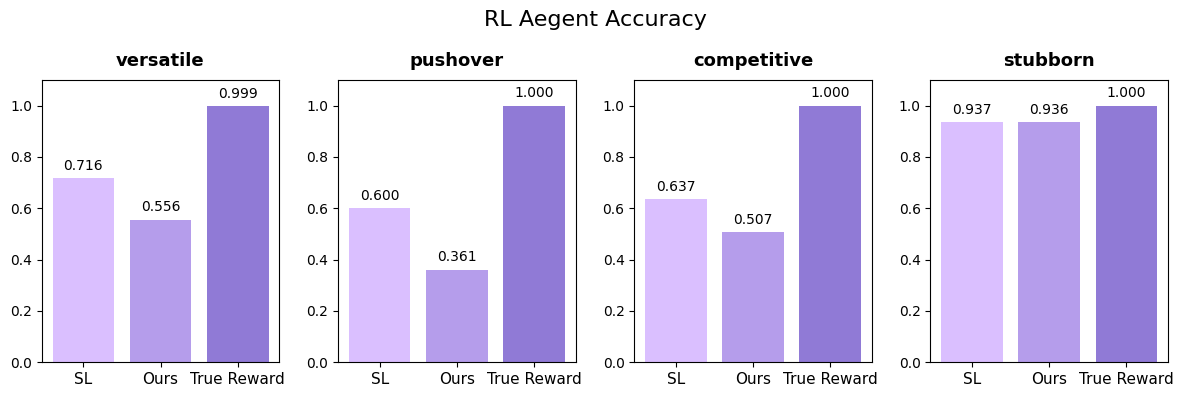

In [ ]:
# данные из экспериментов
SL = {
    'versatile': 0.7161981258366801,
    'pushover': 0.6,
    'competitive': 0.6372155287817939,
    'stubborn': 0.9370816599732262
}

ours = {
    'versatile': 0.556,
    'pushover': 0.36133333333333334,
    'competitive': 0.5066666666666667,
    'stubborn': 0.936
}

true = {
    'versatile': 0.9986666666666667,
    'pushover': 1.0,
    'competitive': 1.0,
    'stubborn': 1.0
}

# создаём четыре подграфика
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('RL Aegent Accuracy', fontsize=16)

# настраиваем графики
subplot_keys = true.keys()

color1 = '#DABFFF'
color2 = '#B59DEB'
color3 = '#907AD6'

# проходим по всем подграфикам
for idx, (ax, key) in enumerate(zip(axes.flat, subplot_keys)):
    # данные для текущего подграфика
    mean1 = SL[key]
    mean2 = ours[key]
    mean3 = true[key]

    # создаем столбцы
    x_pos = [0, 1, 2]
    means = [mean1, mean2, mean3]

    # рисуем их
    bars = ax.bar(x_pos, means, color=[color1, color2, color3])

    # добавлем надписи на ось x
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['SL', 'Ours', 'True Reward'], fontsize=11)

    # устанавливаем пределы по у, от 0 до 1
    ax.set_ylim(0, 1.1)

    # добавляем заголовок
    ax.set_title(key, fontsize=13, fontweight='bold', pad=10)

    # добавляем значения accuracy на график
    for i, (bar, mean_val) in enumerate(zip(bars, means)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.show()

Сравним со статьёй:
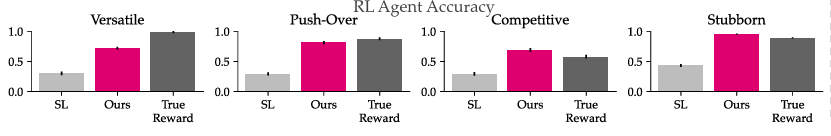

У нас, в отличие от статьи, LLM всегда хуже, чем SL. Возможно, сказывается, что gpt3 -- закрытая модель, более качественная, а та, которую мы выбрали, -- не самая сильная с HF, зато дешёвая. При этом удивительно, что SL у нас во всех случаях значительно выше, чем в статье.

Теперь посмотрим на Labeling Accuracy:

In [ ]:
for style, model in itertools.product(styles, models):
    print(f"\n{'='*60}")
    print(f"Running: style={style}, model={model}")
    print(f"{'='*60}")
    !python eval.py --style {style} --model {model}


Running: style=stubborn, model=gpt3
[np.float64(0.064), np.float64(0.064), np.float64(0.06)]
mean:  0.06266666666666666 std:  0.2423309050152219

Running: style=versatile, model=gpt3
[np.float64(0.252), np.float64(0.28), np.float64(0.32)]
mean:  0.28400000000000003 std:  0.44987876612117006

Running: style=competitive, model=gpt3
[np.float64(0.348), np.float64(0.352), np.float64(0.368)]
mean:  0.35600000000000004 std:  0.47873044186826047

Running: style=pushover, model=gpt3
[np.float64(0.516), np.float64(0.512), np.float64(0.5)]
mean:  0.5093333333333333 std:  0.49986663789615


Строим общий график для Labeling Accuracy

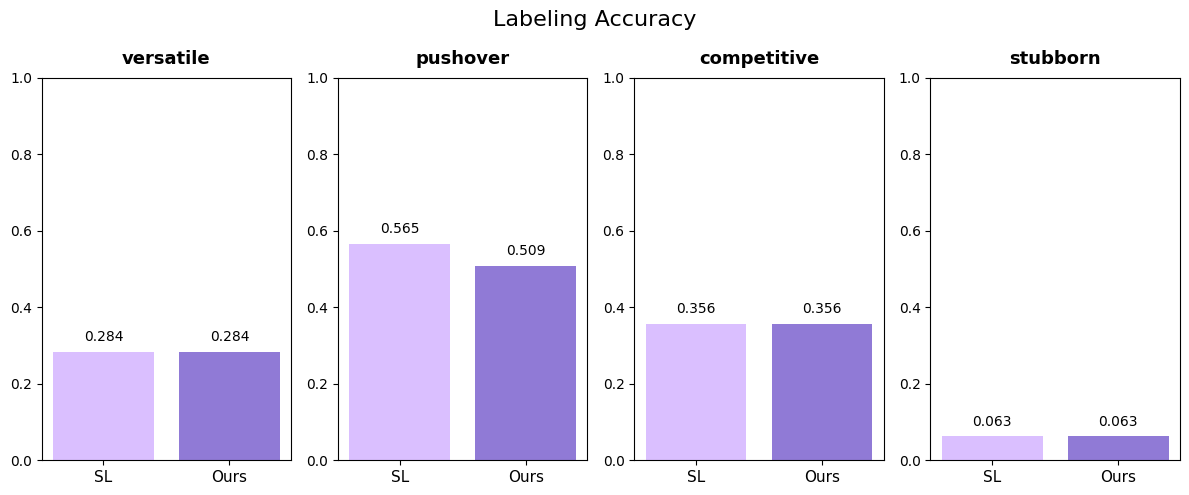

In [ ]:
# данные из экспериментов
SL = {
    'versatile': 0.28400000000000003,
    'pushover': 0.5653333333333334,
    'competitive': 0.35600000000000004,
    'stubborn': 0.06266666666666666
}

ours = {
    'versatile': 0.28400000000000003,
    'pushover': 0.5093333333333333,
    'competitive':  0.35600000000000004 ,
    'stubborn': 0.06266666666666666
}

fig, axes = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle('Labeling Accuracy', fontsize=16)

subplot_keys = SL.keys()

color1 = '#DABFFF'
color2 = '#907AD6'

# проходим по всем подграфикам
for idx, (ax, key) in enumerate(zip(axes.flat, subplot_keys)):
    # данные для текущего подграфика
    mean2 = ours[key]
    mean1 = SL[key]

    # создаем столбцы
    x_pos = [0, 1]
    means = [mean1, mean2]

    # рисуем их
    bars = ax.bar(x_pos, means, color=[color1, color2])

    # добавлем надписи на ось x
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['SL', 'Ours'], fontsize=11)

    # устанавливаем пределы по у, от 0 до 1
    ax.set_ylim(0, 1)

    # добавляем заголовок
    ax.set_title(key, fontsize=13, fontweight='bold', pad=10)

    # добавляем значения accuracy на график
    for i, (bar, mean_val) in enumerate(zip(bars, means)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.show()

Сравним со статьёй:
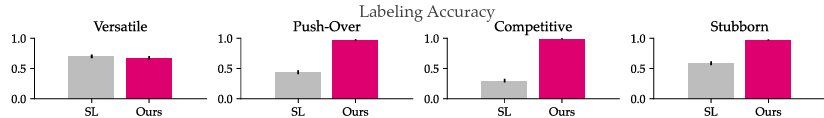

У нас почти всегда результаты для SL и для LLM похожи, в статье разница между LLM и SL более заметна. Вероятно, потому, что LLM там более "качественная", а у нас достаточно дешёвая, причём ещё узкоспециализированная: обучена для диалогов, а не общая.